In [1]:
from pyspark.sql import SparkSession
import pyspark.sql.functions as F
from pyspark.sql.functions import col

spark = SparkSession.builder.appName("mbd-prj").getOrCreate()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/01/10 12:14:09 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [2]:
from pyspark.sql.functions import col, count, countDistinct, when, concat
from matplotlib import pyplot as plt
import numpy as np
from pyspark.sql import Window
from pyspark.sql.types import StructType, StructField, StringType, IntegerType, ArrayType
from pyspark.sql.functions import udf
from pyspark.sql import Row
import seaborn as sns
from tqdm import tqdm


# Reading the datasets

In [3]:
from pathlib import Path
lymsys_folder = Path("/Users/lgk1910/Library/CloudStorage/OneDrive-AaltoUniversity/Learning2/Big Data/Project/data/lmsys-chat-1m")
wildchat_folder = Path("/Users/lgk1910/Library/CloudStorage/OneDrive-AaltoUniversity/Learning2/Big Data/Project/data/WildChat-1M-Full/WildChat-1M-Full/")

In [4]:
# test reading the dataset from a folder of parquet files
lymsys_df = spark.read.parquet(str(lymsys_folder))
lymsys_df.show(5)
wildchat_df = spark.read.parquet(str(wildchat_folder))
wildchat_df.show(5)


+--------------------+----------+-----------------------------------+----+----------+--------------------+--------+
|     conversation_id|     model|                       conversation|turn|  language|   openai_moderation|redacted|
+--------------------+----------+-----------------------------------+----+----------+--------------------+--------+
|c20948192699451b8...|vicuna-13b|               [{Given the artic...|   1|   English|[{{false, false, ...|    true|
|8b02aa2df44847a1b...|vicuna-33b|               [{Alright, let's ...|   2|   English|[{{false, false, ...|    true|
|c18f3612fac140cb9...|vicuna-13b|[{あなたが最終更新されたのはいつ...|   5|  Japanese|[{{false, false, ...|   false|
|d1fabb62e3364665a...| llama-13b|               [{You are an AI a...|   1|   English|[{{false, false, ...|    true|
|b2da335248f04e439...| koala-13b|               [{Reescreva esse ...|   1|Portuguese|[{{false, false, ...|   false|
+--------------------+----------+-----------------------------------+----+----------+--

In [5]:
# number of rows in each dataset
print(lymsys_df.count())
print(wildchat_df.count())

1000000
990372


In [6]:
lymsys_first_10_pd = lymsys_df.limit(10).toPandas()
wild_first_10_pd = wildchat_df.limit(10).toPandas()

# Sample codes

In [6]:
# get the first row that whoses conversation size is greater than 2
lym_first_mul_conv = [lymsys_df.filter(F.size(col("conversation")) > 2).first()]
wild_first_mul_conv = [wildchat_df.filter(F.size(col("conversation")) > 2).first()]

In [7]:
# collect all header.user_agent from users, only take first 10
z = wildchat_df.select("hashed_ip", "header.accept-language", "header.user-agent").distinct().sort("hashed_ip").limit(100)
# count group by hashed_ip, filter by count > 1, take first 10
y = z.groupBy("hashed_ip").count().sort("hashed_ip").filter(col("count") > 1).limit(100).collect()
# filter out from z hashed_ip == '000d7b547ba8018da6976b037058a96b71d4ea9832d3ce40f9b35936987c60ef'
z = wildchat_df.filter(col("hashed_ip") == '0016ccd60404d131a67b492642c677287c7299fb0139945a3270b14f2b66921f').collect()

In [8]:
print(wildchat_df.groupBy("hashed_ip").count().filter(col("count") > 1).count())
print(wildchat_df.groupBy("hashed_ip").count().count())


84547


188517


In [9]:
# take the column 'conversation' from the first row of the dataframe, convert it to a list
lym_conv_sample = lymsys_df.select('conversation').first().conversation
print(lym_conv_sample[0].asDict().keys())
wild_conv_sample = wildchat_df.select('conversation').first().conversation
print(wild_conv_sample[0].asDict().keys())

dict_keys(['content', 'role'])
dict_keys(['content', 'country', 'hashed_ip', 'header', 'language', 'redacted', 'role', 'state', 'timestamp', 'toxic', 'turn_identifier'])


In [10]:
wildchat_df.select('header').first().header


Row(accept-language='en-US,en;q=0.9', user-agent='Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/116.0.0.0 Safari/537.36')

In [11]:
wildchat_df.filter(wildchat_df.header['user-agent'] == 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/116.0.0.0 Safari/537.36').count()


28341

In [12]:
wild_user_count = wildchat_df.groupBy('hashed_ip', 'header.accept-language').count()
print(f'{wild_user_count.count() = }')

wild_user_count.count() = 213440


In [13]:
# search all rows with hashed_ip = 'f96c8515aa663db23ee086f36b7d3642036d5394bbbeada3fe0c6c8285f4d314'
wild_ip = 'f96c8515aa663db23ee086f36b7d3642036d5394bbbeada3fe0c6c8285f4d314'
wild_ip_df = wildchat_df.filter(col('hashed_ip') == wild_ip)
wild_ip_df.show(5)


+--------------------+------------------+-------------------+--------------------+----+--------+--------------------+--------------------+-----+--------+--------+-------------+--------------------+--------------------+
|   conversation_hash|             model|          timestamp|        conversation|turn|language|   openai_moderation| detoxify_moderation|toxic|redacted|   state|      country|           hashed_ip|              header|
+--------------------+------------------+-------------------+--------------------+----+--------+--------------------+--------------------+-----+--------+--------+-------------+--------------------+--------------------+
|f01a345e668b978b6...|gpt-3.5-turbo-0613|2023-09-13 04:14:27|[{(In the clubroo...|   1| English|[{{false, false, ...|[{2.1957975695841...|false|   false|Michigan|United States|f96c8515aa663db23...|{en-US,en;q=0.9, ...|
|136971e6080d62e86...|gpt-3.5-turbo-0613|2023-09-13 09:40:52|[{(In the clubroo...|   1| English|[{{false, false, ...|[{2.195

In [14]:
# count number of unique conversation_id in lymsys_df
lym_conv_count = lymsys_df.select('conversation_id').distinct().count()
print(lym_conv_count)
# number of rows
lym_row_count = lymsys_df.count()
print(lym_row_count)

1000000
1000000


# Question 1: What percentage of users have multiple conversations?
- WildChat: Use combination of `hashed_ip` and `header` to estimate number of repeat users

In [16]:
# count number of users, group by hashed_ip and header.user-agent
wild_user_count = wildchat_df.groupBy('hashed_ip', 'header.user-agent').count()
print(f'{wild_user_count.count() = }')
# count number of users, group by hashed_ip only
wild_user_count = wildchat_df.groupBy('hashed_ip').count()
print(f'{wild_user_count.count() = }')


wild_user_count.count() = 241796
wild_user_count.count() = 188517


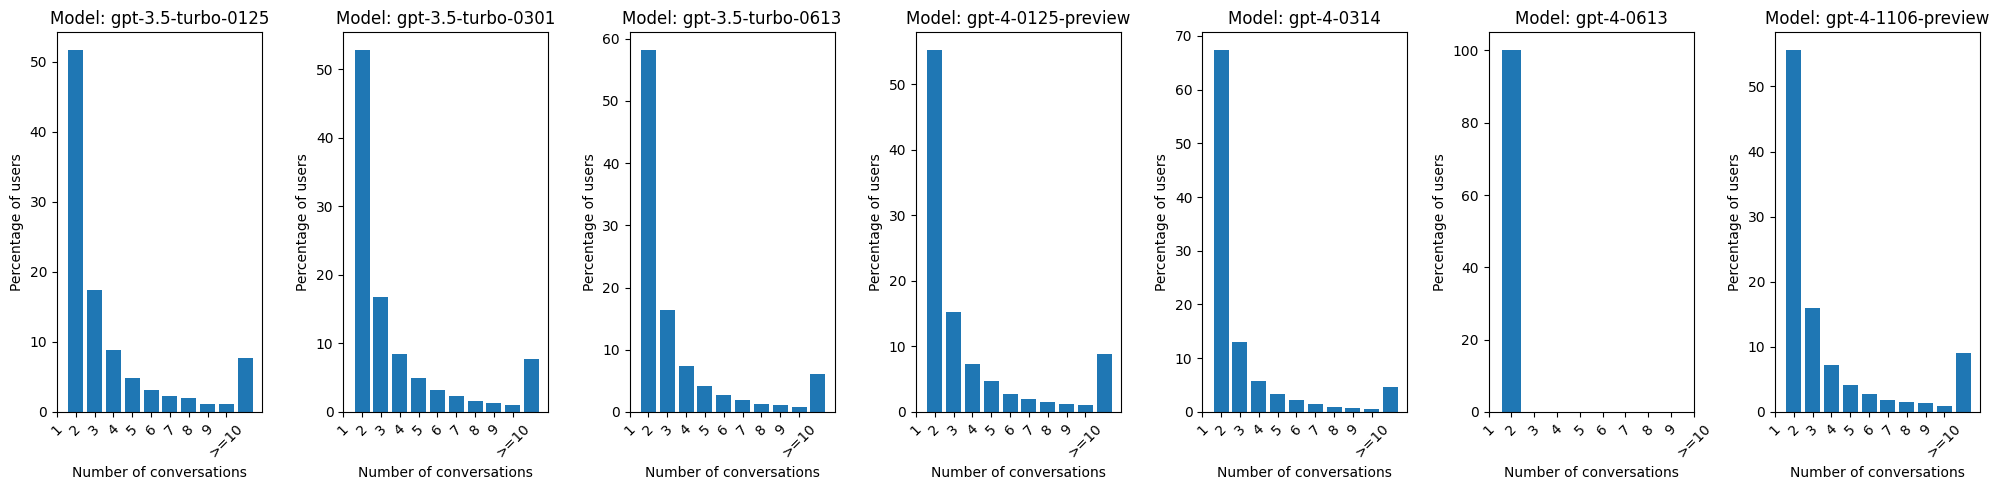

                 model  conversation_count  user_count  percentage
0   gpt-3.5-turbo-0125                   1        7024   51.628078
1   gpt-3.5-turbo-0125                   2        2371   17.427416
2   gpt-3.5-turbo-0125                   3        1201    8.827637
3   gpt-3.5-turbo-0125                   4         653    4.799706
4   gpt-3.5-turbo-0125                   5         426    3.131202
..                 ...                 ...         ...         ...
56  gpt-4-1106-preview                   6         383    1.859043
57  gpt-4-1106-preview                   7         302    1.465877
58  gpt-4-1106-preview                   8         270    1.310552
59  gpt-4-1106-preview                   9         183    0.888263
60  gpt-4-1106-preview                  10        1862    9.037957

[61 rows x 4 columns]


In [17]:
# Group by model and count conversations per user
# model_user_counts = wildchat_df.groupBy("composite_key", "model").count()
model_user_counts = wildchat_df.groupBy("hashed_ip", "model").count()

# Create distribution per model 
model_conversation_counts = model_user_counts.groupBy("model", "count")\
	.agg(F.count("*").alias("user_count"))\
	.orderBy("model", "count")

# Group counts >= 10 together
model_conversation_counts = model_conversation_counts.withColumn(
	"conversation_count",
	when(col("count") < 10, col("count")).otherwise(10)
)

# Aggregate after grouping
model_conversation_counts = model_conversation_counts.groupBy("model", "conversation_count")\
	.agg(F.sum("user_count").alias("user_count"))\
	.orderBy("model", "conversation_count")

# Convert to pandas for easier plotting
model_df = model_conversation_counts.toPandas()

# Calculate percentages per model
model_df['percentage'] = model_df.groupby('model')['user_count'].transform(
	lambda x: (x / x.sum()) * 100
)

# Create subplots for each model
models = model_df['model'].unique()
fig, axes = plt.subplots(1, len(models), figsize=(20, 5))

for i, model in enumerate(models):
	model_data = model_df[model_df['model'] == model]
	axes[i].bar(model_data['conversation_count'], model_data['percentage'])
	axes[i].set_title(f'Model: {model}')
	axes[i].set_xlabel('Number of conversations')
	axes[i].set_ylabel('Percentage of users')
	axes[i].set_xticks(range(10))
	axes[i].set_xticklabels([str(i) for i in range(1, 10)] + ['>=10'], rotation=45)

plt.tight_layout()
plt.show()
print(model_df)

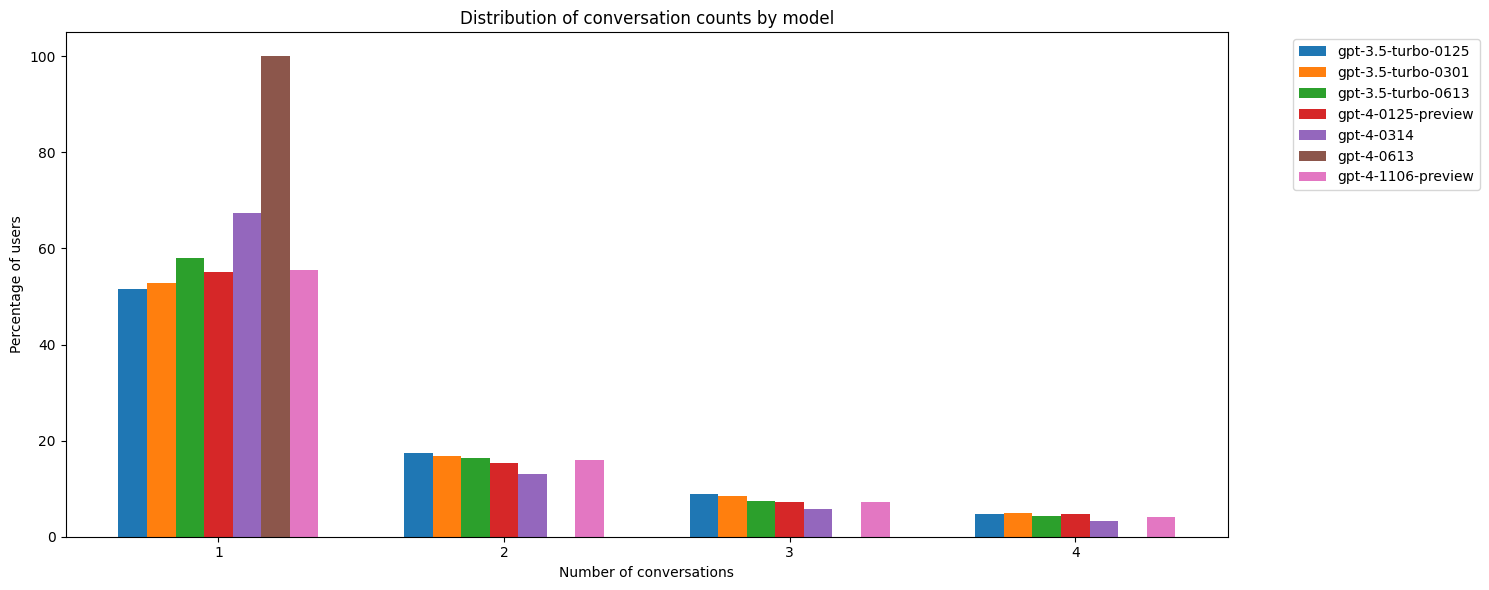

In [18]:
# Create a bar plot for conversation counts 1-4 across all models
conv_counts = [1, 2, 3, 4]
width = 0.1
x = np.arange(len(conv_counts))

plt.figure(figsize=(15, 6))

for i, model in enumerate(models):
	model_data = model_df[model_df['model'] == model]
	# Get only the rows with conversation_count in conv_counts
	model_data = model_data[model_data['conversation_count'].isin(conv_counts)]
	# Some models might not have all conversation counts, so we need to handle missing values
	percentages = []
	for conv_count in conv_counts:
		matching_row = model_data[model_data['conversation_count'] == conv_count]
		if len(matching_row) > 0:
			percentages.append(matching_row.iloc[0]['percentage'])
		else:
			percentages.append(0)
	
	plt.bar(x + i*width, percentages, width, label=model)

plt.xlabel('Number of conversations')
plt.ylabel('Percentage of users')
plt.title('Distribution of conversation counts by model')
plt.xticks(x + (len(models)-1)*width/2, conv_counts)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

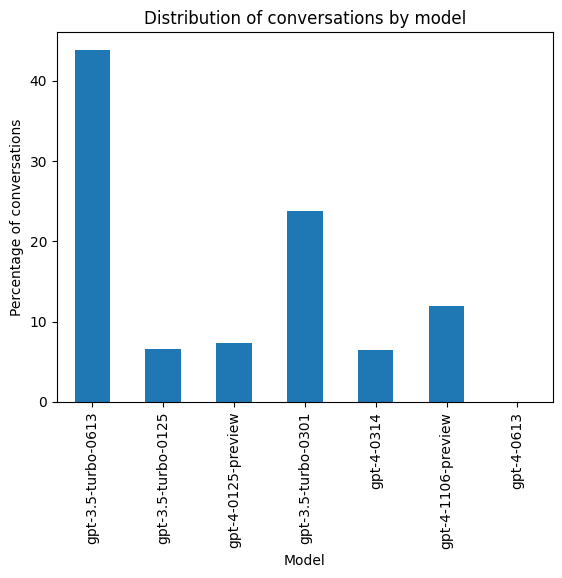

In [19]:
# Create a bar plot comparing all models and their number of conversations
# group by model
model_conversation_counts = wildchat_df.groupBy("model").count()
# convert them into percentages
model_conversation_counts = model_conversation_counts.withColumn(
	"percentage",
	(col("count") / wildchat_df.count()) * 100
)
# plot bar plot
model_conversation_counts.toPandas().plot.bar(x="model", y="percentage", legend=False)
plt.xlabel("Model")
plt.ylabel("Percentage of conversations")
plt.title("Distribution of conversations by model")
plt.show()


+------------+------+------------------+
|model_family| count|        percentage|
+------------+------+------------------+
|     GPT-3.5|735709| 74.28612682911067|
|       GPT-4|254663|25.713873170889322|
+------------+------+------------------+

None


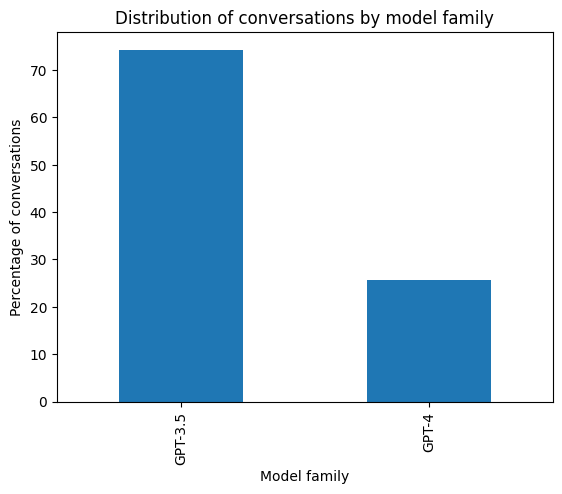

In [20]:
# Create a new column 'model_family' based on the model name
wildchat_df = wildchat_df.withColumn(
	"model_family",
	F.when(F.col("model").like("gpt-3.5%"), "GPT-3.5")
	 .when(F.col("model").like("gpt-4%"), "GPT-4")
	 .otherwise("Other")
)

# Group by model family and count conversations
model_family_counts = wildchat_df.groupBy("model_family").count()
# convert to percentages
model_family_counts = model_family_counts.withColumn(
	"percentage",
	(col("count") / wildchat_df.count()) * 100
)
print(model_family_counts.show())

# Convert to pandas for plotting
model_family_counts_pd = model_family_counts.toPandas()
model_family_counts_pd.plot.bar(x="model_family", y="percentage", legend=False)
plt.xlabel("Model family")
plt.ylabel("Percentage of conversations")
plt.title("Distribution of conversations by model family")
plt.show()


                model  avg_turns
0  gpt-3.5-turbo-0613   2.157038
1  gpt-3.5-turbo-0125   1.817120
2  gpt-4-0125-preview   3.216763
3  gpt-3.5-turbo-0301   3.121775
4          gpt-4-0314   1.888456
5  gpt-4-1106-preview   3.040836
6          gpt-4-0613   1.500000


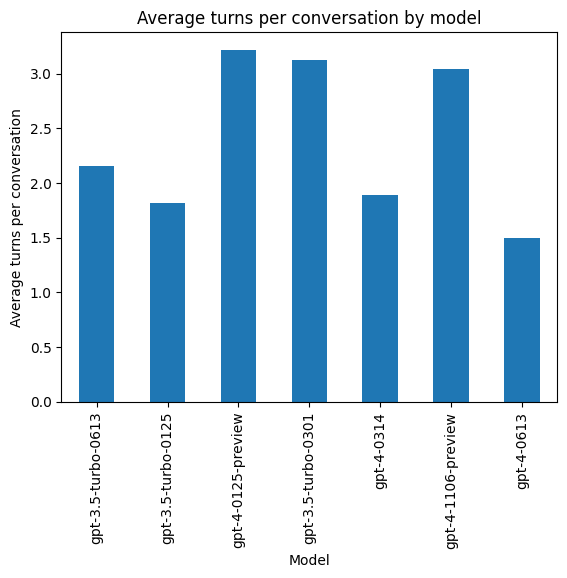

  model_family  avg_turns
0      GPT-3.5   2.435805
1        GPT-4   2.801235


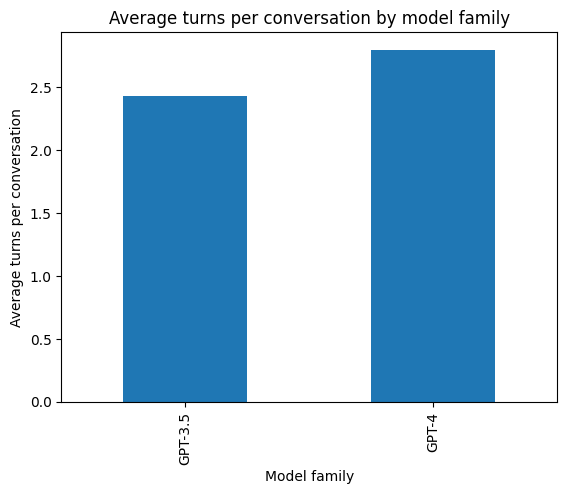

In [21]:
# Construct a bar graph to see the percentage of avg turns per conversation for each model, there's a column called `turn` in the dataset
avg_turns = wildchat_df.groupBy("model").agg(F.avg("turn").alias("avg_turns"))
avg_turns_pd = avg_turns.toPandas()
print(avg_turns_pd)
avg_turns_pd.plot.bar(x="model", y="avg_turns", legend=False)
plt.xlabel("Model")
plt.ylabel("Average turns per conversation")
plt.title("Average turns per conversation by model")
plt.show()

# Now, instead of grouping by model, group by model_family
avg_turns = wildchat_df.groupBy("model_family").agg(F.avg("turn").alias("avg_turns"))
avg_turns_pd = avg_turns.toPandas()
print(avg_turns_pd)
avg_turns_pd.plot.bar(x="model_family", y="avg_turns", legend=False)
plt.xlabel("Model family")
plt.ylabel("Average turns per conversation")
plt.title("Average turns per conversation by model family")
plt.show()


+------------+----+------+------------------+
|model_family|turn| count|        percentage|
+------------+----+------+------------------+
|     GPT-3.5|   1|439457| 59.73244856322268|
|     GPT-3.5|   9|  7310|0.9935993714906302|
|     GPT-3.5|   5| 24799| 3.370762081203302|
|     GPT-3.5|   4| 37003|  5.02957011535811|
|     GPT-3.5|   6| 17827| 2.423104787354783|
|     GPT-3.5|   7| 12942|1.7591194344503058|
|     GPT-3.5|   3| 58326| 7.927862782703487|
|     GPT-3.5|   8|  9642|1.3105725225598708|
|     GPT-3.5|   2|103716| 14.09742167079647|
|     GPT-3.5|  10| 24687|3.3555386708603536|
|       GPT-4|   4| 11941| 4.688941856492698|
|       GPT-4|   7|  4041| 1.586802951351394|
|       GPT-4|   9|  2366|0.9290709682992818|
|       GPT-4|   6|  5614|2.2044820017042133|
|       GPT-4|   2| 38804|15.237392161405467|
|       GPT-4|  10| 12649| 4.966956330523083|
|       GPT-4|   5|  7725| 3.033420638255263|
|       GPT-4|   1|148833| 58.44311894542984|
|       GPT-4|   3| 19571|7.685058

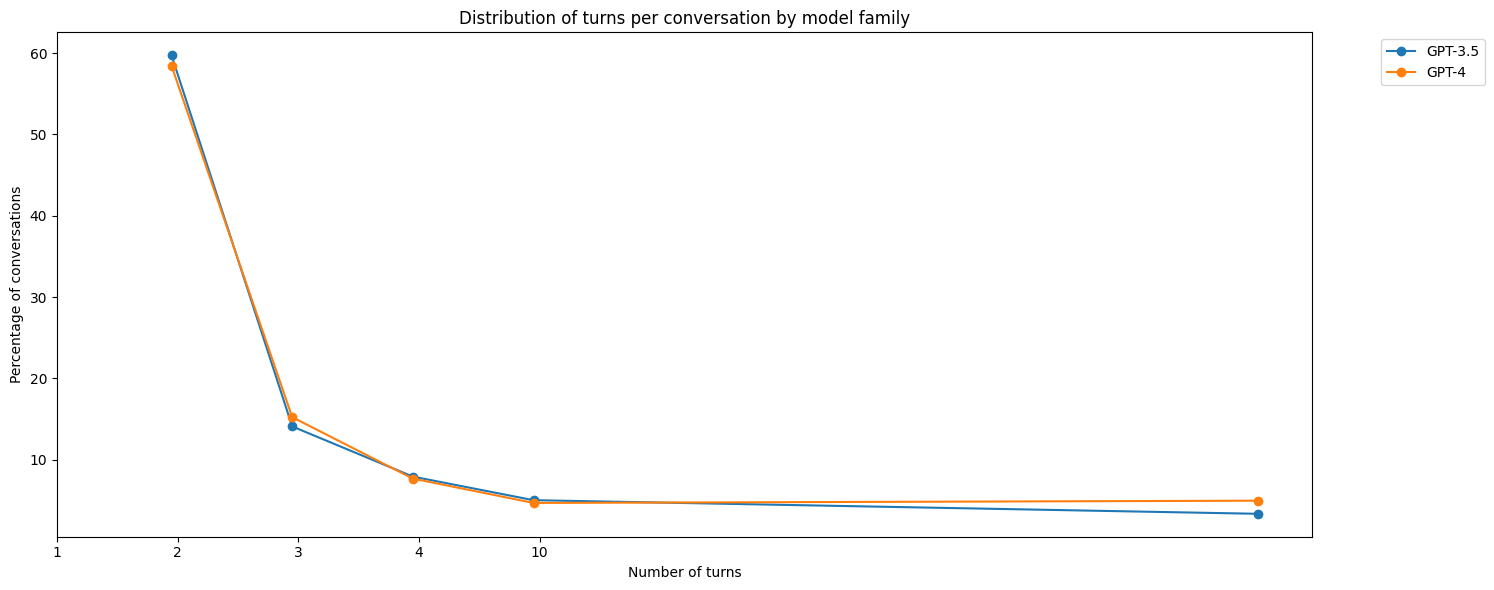

In [22]:
# Now, group by model_family and turn, and count the number of conversations
# map turn >= 10 to 10
turn_counts = wildchat_df.withColumn(
	"turn",
	when(col("turn") < 10, col("turn")).otherwise(10)
)
turn_counts = turn_counts.groupBy("model_family", "turn").count()

# convert to percentages per model family
# count total number of types of turns per model family
total_turns = turn_counts.groupBy("model_family").agg(F.sum("count").alias("total_turns"))
# join total_turns with turn_counts
turn_counts = turn_counts.join(total_turns, "model_family")
# calculate percentage
turn_counts = turn_counts.withColumn(
	"percentage",
	(col("count") / col("total_turns")) * 100
)
# drop total_turns column
turn_counts = turn_counts.drop("total_turns")
# show the results
print(turn_counts.show())

# Plot the distribution of turns per conversation by model family, for each value of turn, plot the models side by side
# Create a bar plot for turn counts 1-4 across all models
turns = [1, 2, 3, 4, 10]
width = 0.1
x = np.arange(len(turns))

plt.figure(figsize=(15, 6))
model_families = turn_counts.select("model_family").distinct().rdd.flatMap(lambda x: x).collect()

turn_counts = turn_counts.toPandas()
for i, model_family in enumerate(model_families):
	model_data = turn_counts[turn_counts['model_family'] == model_family]
	# Get only the rows with turn in turns
	model_data = model_data[model_data['turn'].isin(turns)]
	# Some models might not have all turns, so we need to handle missing values
	percentages = []
	for turn in turns:
		matching_row = model_data[model_data['turn'] == turn]
		if len(matching_row) > 0:
			percentages.append(matching_row.iloc[0]['percentage'])
		else:
			percentages.append(0)

	plt.plot(turns, percentages, marker='o', label=model_family)

plt.xlabel('Number of turns')
plt.ylabel('Percentage of conversations')
plt.title('Distribution of turns per conversation by model family')
plt.xticks(x + (len(model_families)-1)*width/2, turns)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

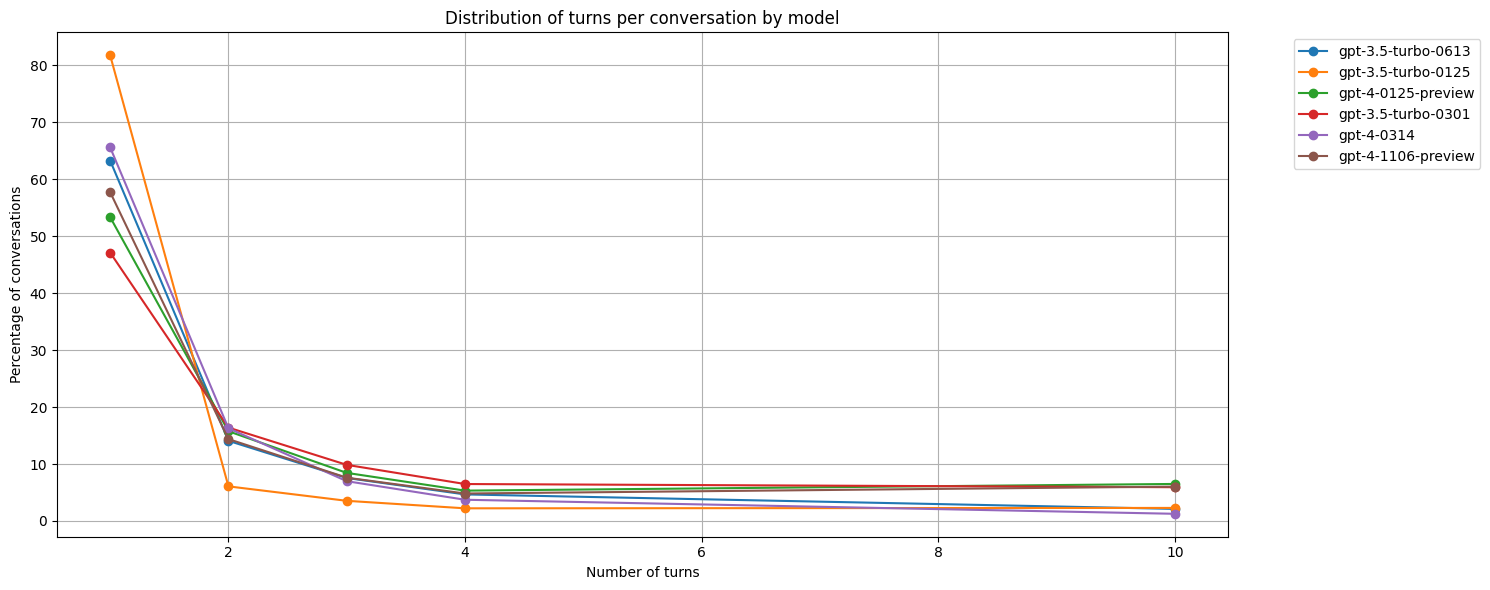

In [23]:
# Now, group by model and turn, and count the number of conversations
# map turn >= 10 to 10
turn_counts = wildchat_df.withColumn(
	"turn",
	when(col("turn") < 10, col("turn")).otherwise(10)
)
turn_counts = turn_counts.groupBy("model", "turn").count()

# convert to percentages per model
# count total number of types of turns per model
total_turns = turn_counts.groupBy("model").agg(F.sum("count").alias("total_turns"))
# join total_turns with turn_counts
turn_counts = turn_counts.join(total_turns, "model")
# calculate percentage
turn_counts = turn_counts.withColumn(
	"percentage",
	(col("count") / col("total_turns")) * 100
)
# drop total_turns column
turn_counts = turn_counts.drop("total_turns")

# Plot the distribution of turns per conversation by model for turns 1-4
turns = [1, 2, 3, 4, 10]
width = 0.1
x = np.arange(len(turns))

plt.figure(figsize=(15, 6))
models = wildchat_df.select("model").distinct().rdd.flatMap(lambda x: x).collect()
# ommit the model gpt-4-0613
models.remove('gpt-4-0613')

turn_counts = turn_counts.toPandas()
for i, model in enumerate(models):
	model_data = turn_counts[turn_counts['model'] == model]
	# Get only the rows with turn in turns
	model_data = model_data[model_data['turn'].isin(turns)]
	# Some models might not have all turns, so we need to handle missing values
	percentages = []
	for turn in turns:
		matching_row = model_data[model_data['turn'] == turn]
		if len(matching_row) > 0:
			percentages.append(matching_row.iloc[0]['percentage'])
		else:
			percentages.append(0)

	plt.plot(turns, percentages, marker='o', label=model)

plt.xlabel('Number of turns')
plt.ylabel('Percentage of conversations')
plt.title('Distribution of turns per conversation by model')
plt.grid(True)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


# Question 2: What is the distribution of conversations per user?
- WildChat: For IP addresses with multiple conversations, plot histogram of conversation counts

In [24]:
# 1. Create analysis on composite_key (already created in cell 14)
wildchat_df = wildchat_df.withColumn(
    "composite_key",
    concat(col("hashed_ip"), F.lit("_"), col("header.user-agent"))
)

# 2. Count conversations per unique user
# user_conversation_counts = wildchat_df.groupBy("composite_key").agg(
# 	count("conversation_hash").alias("conversation_count")
# )
user_conversation_counts = wildchat_df.groupBy("hashed_ip").agg(
	count("conversation_hash").alias("conversation_count")
)

# 3. Calculate statistics
total_users = user_conversation_counts.count()
repeat_users = user_conversation_counts.filter(col("conversation_count") > 1).count()
repeat_percentage = (repeat_users / total_users) * 100

# 4. Show results
print(f"Total unique users: {total_users}")
print(f"Users with multiple conversations: {repeat_users}")
print(f"Percentage of repeat users: {repeat_percentage:.2f}%")


Total unique users: 188517
Users with multiple conversations: 84547
Percentage of repeat users: 44.85%


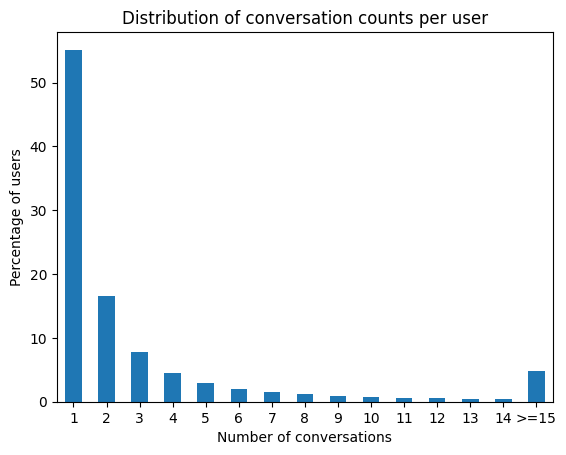

    conversation_count  user_count  percentage
0                    1      103970   55.151525
1                    2       31189   16.544397
2                    3       14582    7.735111
3                    4        8353    4.430900
4                    5        5517    2.926527
5                    6        3868    2.051804
6                    7        2809    1.490051
7                    8        2214    1.174430
8                    9        1735    0.920341
9                   10        1430    0.758552
10                  11        1215    0.644504
11                  12         997    0.528865
12                  13         833    0.441870
13                  14         743    0.394129
14                  15        9062    4.806994


In [25]:
# 5. Optional: Distribution of conversation counts
user_conversation_counts_grouped = user_conversation_counts.groupBy("conversation_count") \
	.agg(count("*").alias("user_count")) \
	.orderBy("conversation_count") \

# 5.1. Group into bins
max_count_cutoff = 15
user_conversation_counts_grouped = user_conversation_counts_grouped.withColumn(
	"conversation_count",
	when(col("conversation_count") < max_count_cutoff, col("conversation_count")).otherwise(max_count_cutoff)
)
user_conversation_counts_grouped = user_conversation_counts_grouped.groupBy("conversation_count") \
	.agg(F.sum("user_count").alias("user_count")) \
	.orderBy("conversation_count")

# 6. Plot distribution, plot in % scale
# Calculate total users for percentage
total = user_conversation_counts_grouped.agg(F.sum("user_count")).collect()[0][0]
# Convert to pandas and calculate percentage
df_plot = user_conversation_counts_grouped.toPandas()
df_plot['percentage'] = (df_plot['user_count'] / total) * 100
# Create the plot
df_plot.plot.bar(x="conversation_count", y="percentage", legend=False)
plt.xticks(range(max_count_cutoff), [str(i) for i in range(1, max_count_cutoff)] + [f'>={max_count_cutoff}'], rotation=0)  # Changed this line
plt.xlabel("Number of conversations")
plt.ylabel("Percentage of users")
plt.title("Distribution of conversation counts per user")
plt.show()
print(df_plot)

# Question 3: Does frequency of user engagement correlate with conversation length?
- WildChat: Compare avg turns per sample for one-time vs repeat users

* Note: we define repeat users as user who have more than 3 conversations

In [26]:
user_counts = wildchat_df.groupBy("hashed_ip").agg(F.count("*").alias("conv_count"))

# Create a binary column for repeat users or not (count > 3)
user_counts = user_counts.withColumn(
	"repeat_user",
	F.when(F.col("conv_count") > 3, 1).otherwise(0)
)

# Count, group by turn and repeat_user
turn_counts = user_counts.groupBy("repeat_user", "conv_count").count()
# Create df of repeat users and non-repeat users
repeat_users = turn_counts.filter(F.col("repeat_user") == 1)
non_repeat_users = turn_counts.filter(F.col("repeat_user") == 0)

# Count, group by turn on each df
repeat_turn_counts = repeat_users.groupBy("conv_count").agg(F.sum("count").alias("count")).orderBy("conv_count")
non_repeat_turn_counts = non_repeat_users.groupBy("conv_count").agg(F.sum("count").alias("count")).orderBy("conv_count")

# Create a column that represents corresponding percentages
# First, calculate total count for each group
total_repeat = repeat_turn_counts.agg(F.sum("count")).collect()[0][0]
total_non_repeat = non_repeat_turn_counts.agg(F.sum("count")).collect()[0][0]
# Calculate percentages
repeat_turn_counts = repeat_turn_counts.withColumn("percentage", (F.col("count") / total_repeat) * 100)
non_repeat_turn_counts = non_repeat_turn_counts.withColumn("percentage", (F.col("count") / total_non_repeat) * 100)

repeat_turn_counts.show(5)
non_repeat_turn_counts.show(5)

+----------+-----+------------------+
|conv_count|count|        percentage|
+----------+-----+------------------+
|         4| 8353| 21.54167526304931|
|         5| 5517|14.227872911079018|
|         6| 3868|  9.97524241799051|
|         7| 2809|   7.2441716525686|
|         8| 2214| 5.709717350938725|
+----------+-----+------------------+
only showing top 5 rows

+----------+------+-----------------+
|conv_count| count|       percentage|
+----------+------+-----------------+
|         1|103970|69.43322136221877|
|         2| 31189|20.82863076912803|
|         3| 14582|9.738147868653208|
+----------+------+-----------------+



In [27]:
# Calculate avg turn per conversation for every user
avg_turns = wildchat_df.groupBy("hashed_ip").agg(F.avg("turn").alias("avg_turns"))

# Join the two dataframes
avg_turns = avg_turns.join(user_counts, "hashed_ip") # avg turns per user

# Calculate avg turn per conversation for repeat users and non-repeat users
avg_turns_repeat = avg_turns.filter(F.col("repeat_user") == 1).agg(F.avg("avg_turns")).collect()[0][0]
avg_turns_non_repeat = avg_turns.filter(F.col("repeat_user") == 0).agg(F.avg("avg_turns")).collect()[0][0]

print(f"Average turns per conversation for repeat users: {avg_turns_repeat:.2f}")
print(f"Average turns per conversation for non-repeat users: {avg_turns_non_repeat:.2f}")

# Calculate median turn per conversation for repeat users and non-repeat users
median_turns_repeat = avg_turns.filter(F.col("repeat_user") == 1).approxQuantile("avg_turns", [0.5], 0.001)[0]
median_turns_non_repeat = avg_turns.filter(F.col("repeat_user") == 0).approxQuantile("avg_turns", [0.5], 0.001)[0]

print(f"Median turns per conversation for repeat users: {median_turns_repeat:.2f}")
print(f"Median turns per conversation for non-repeat users: {median_turns_non_repeat:.2f}")


Average turns per conversation for repeat users: 2.86
Average turns per conversation for non-repeat users: 2.58


Median turns per conversation for repeat users: 2.22
Median turns per conversation for non-repeat users: 1.50


In [28]:
# Calculate the histogram of turns per conversation for repeat users and non-repeat users 
# Using deciles (10 bins) for more granular distribution
bin_threshold_repeat = avg_turns.filter(F.col("repeat_user") == 1).approxQuantile("avg_turns", 
	[i/10.0 for i in range(11)], # 0.0, 0.1, 0.2, ..., 1.0
	0.001)

bin_threshold_non_repeat = avg_turns.filter(F.col("repeat_user") == 0).approxQuantile("avg_turns",
	[i/10.0 for i in range(11)], # 0.0, 0.1, 0.2, ..., 1.0  
	0.001)

# Print the results
print("Bins for the histogram of turns per conversation for repeat users:")
print(bin_threshold_repeat)
print("Bins for the histogram of turns per conversation for non-repeat users:")
print(bin_threshold_non_repeat)

# Create a column to assign corresponding bin to each user
# Create a function to assign bins based on thresholds
def assign_bin_for_repeat(value, thresholds):
	for i in range(len(thresholds)-1):
		if value >= thresholds[i] and value < thresholds[i+1]:
			return i
	return len(thresholds)-2

def assign_bin_for_non_repeat(value, thresholds):
	for i in range(len(thresholds)-1):
		if value >= thresholds[i] and value < thresholds[i+1]:
			return i
	return len(thresholds)-2

# Create two separate DataFrames for repeat and non-repeat users
avg_turns_repeat = avg_turns.filter(F.col("repeat_user") == 1)
avg_turns_non_repeat = avg_turns.filter(F.col("repeat_user") == 0)

# Create UDFs for the bin assignment
assign_bin_repeat_udf = udf(lambda x: assign_bin_for_repeat(x, bin_threshold_repeat), IntegerType())
assign_bin_non_repeat_udf = udf(lambda x: assign_bin_for_non_repeat(x, bin_threshold_non_repeat), IntegerType())

# Assign bins to each user
avg_turns_repeat = avg_turns_repeat.withColumn("bin", assign_bin_repeat_udf(F.col("avg_turns")))
avg_turns_non_repeat = avg_turns_non_repeat.withColumn("bin", assign_bin_non_repeat_udf(F.col("avg_turns")))
avg_turns_repeat.show(5)
avg_turns_non_repeat.show(5)

# Group by bin and count the number of users
repeat_bin_counts = avg_turns_repeat.groupBy("bin").count().orderBy("bin")
non_repeat_bin_counts = avg_turns_non_repeat.groupBy("bin").count().orderBy("bin")

# Calculate total users for percentage
total_repeat = avg_turns_repeat.count()
total_non_repeat = avg_turns_non_repeat.count()

# Calculate percentages
repeat_bin_counts = repeat_bin_counts.withColumn("percentage", (F.col("count") / total_repeat) * 100)
non_repeat_bin_counts = non_repeat_bin_counts.withColumn("percentage", (F.col("count") / total_non_repeat) * 100)

repeat_bin_counts.show(5)
non_repeat_bin_counts.show(5)

Bins for the histogram of turns per conversation for repeat users:
[1.0, 1.0, 1.1428571428571428, 1.5, 1.8181818181818181, 2.2222222222222223, 2.6666666666666665, 3.2, 4.0, 5.30188679245283, 56.6]
Bins for the histogram of turns per conversation for non-repeat users:
[1.0, 1.0, 1.0, 1.0, 1.0, 1.5, 2.0, 2.5, 3.5, 5.0, 132.0]


+--------------------+------------------+----------+-----------+---+
|           hashed_ip|         avg_turns|conv_count|repeat_user|bin|
+--------------------+------------------+----------+-----------+---+
|00073b9ff305f8693...|1.1666666666666667|         6|          1|  2|
|000aa94bb8c8c7868...|               2.6|         5|          1|  5|
|000f22bb6abf4e96e...|               1.0|         6|          1|  1|
|00130c75d1bb6b7ed...|2.8333333333333335|         6|          1|  6|
|0016ccd60404d131a...|             1.625|         8|          1|  3|
+--------------------+------------------+----------+-----------+---+
only showing top 5 rows



+--------------------+---------+----------+-----------+---+
|           hashed_ip|avg_turns|conv_count|repeat_user|bin|
+--------------------+---------+----------+-----------+---+
|00068e0c2bd27cca7...|      4.0|         1|          0|  8|
|000e15c1a7503cf5e...|      1.0|         1|          0|  4|
|001100154879561ff...|      9.0|         1|          0|  9|
|0015339487d414417...|     10.0|         1|          0|  9|
|001b1d4f5ca117166...|      1.0|         1|          0|  4|
+--------------------+---------+----------+-----------+---+
only showing top 5 rows



+---+-----+------------------+
|bin|count|        percentage|
+---+-----+------------------+
|  1| 7711|19.886011966164638|
|  2| 3726| 9.609036517433465|
|  3| 4033|10.400763358778626|
|  4| 3836| 9.892717144625541|
|  5| 3831| 9.879822570662265|
+---+-----+------------------+
only showing top 5 rows



+---+-----+------------------+
|bin|count|        percentage|
+---+-----+------------------+
|  4|70288| 46.93971590947035|
|  5| 6261| 4.181219572461784|
|  6|25567|17.074148028929955|
|  7|17251|11.520558831582532|
|  8|11093|  7.40812469530723|
+---+-----+------------------+
only showing top 5 rows



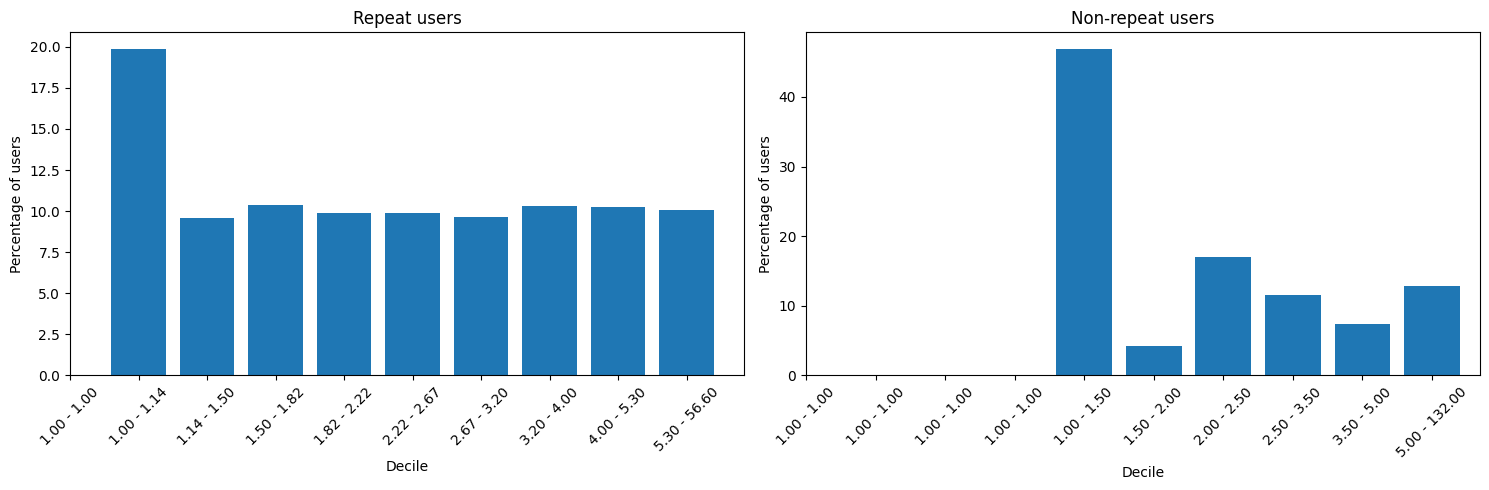

In [29]:
# Plot the histogram of turns per conversation for repeat users and non-repeat users
# Convert to pandas for plotting
repeat_bin_counts_pd = repeat_bin_counts.toPandas()
non_repeat_bin_counts_pd = non_repeat_bin_counts.toPandas()
# Create the plot
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

axes[0].bar(repeat_bin_counts_pd["bin"], repeat_bin_counts_pd["percentage"])
axes[0].set_title("Repeat users")
axes[0].set_xlabel("Decile")
axes[0].set_ylabel("Percentage of users")
axes[0].set_xticks(range(10))
# set xticks, round to 2 decimal places
axes[0].set_xticklabels([f"{bin_threshold_repeat[int(i)]:.2f} - {bin_threshold_repeat[int(i+1)]:.2f}" for i in range(len(bin_threshold_repeat)) if i < len(bin_threshold_repeat) - 1], rotation=45)

axes[1].bar(non_repeat_bin_counts_pd["bin"], non_repeat_bin_counts_pd["percentage"])
axes[1].set_title("Non-repeat users")
axes[1].set_xlabel("Decile")
axes[1].set_ylabel("Percentage of users")
axes[1].set_xticks(range(10))
axes[1].set_xticklabels([f"{bin_threshold_non_repeat[int(i)]:.2f} - {bin_threshold_non_repeat[int(i+1)]:.2f}" for i in range(len(bin_threshold_non_repeat)) if i < len(bin_threshold_non_repeat) - 1], rotation=45)
plt.tight_layout()
plt.show()

# Question 4: What is the most common time gap between a user's conversations?
- WildChat: For repeat users, find median time between their conversation timestamps
- Lymsys: Use assistant turn timestamps to characterize typical response times
* Note: we define repeat users as user who have more than 3 conversations

In [17]:
user_counts = wildchat_df.groupBy("hashed_ip").agg(F.count("*").alias("conv_count"))

# Create a binary column for repeat users or not (count > 3)
user_counts = user_counts.withColumn(
	"repeat_user",
	F.when(F.col("conv_count") > 3, 1).otherwise(0)
)

# Calculate avg time gap between conversations for every user
# First, convert timestamp to unix timestamp

# Convert timestamp to unix timestamp
wildchat_df = wildchat_df.withColumn("timestamp_unix", F.unix_timestamp("timestamp"))

# Calculate time gap between conversations for each user
# First, sort by timestamp
window = Window.partitionBy("hashed_ip").orderBy("timestamp_unix")
wildchat_df = wildchat_df.withColumn("time_gap", F.col("timestamp_unix") - F.lag("timestamp_unix").over(window)) # time gap between conversations

In [18]:
# Calculate avg time gap per user
avg_time_gap = wildchat_df.groupBy("hashed_ip").agg(F.avg("time_gap").alias("avg_time_gap"))

# Join the two dataframes
avg_time_gap = avg_time_gap.join(user_counts, "hashed_ip") # avg time gap per user

# Calculate avg time gap between conversations for repeat users and non-repeat users
avg_time_gap_repeat = avg_time_gap.filter(F.col("repeat_user") == 1).agg(F.avg("avg_time_gap")).collect()[0][0]
avg_time_gap_non_repeat = avg_time_gap.filter(F.col("repeat_user") == 0).agg(F.avg("avg_time_gap")).collect()[0][0]
print(f"Average time gap between conversations for repeat users: {avg_time_gap_repeat/3600:.2f} hours")
print(f"Average time gap between conversations for non-repeat users: {avg_time_gap_non_repeat/3600:.2f} hours")


Average time gap between conversations for repeat users: 118.58 hours
Average time gap between conversations for non-repeat users: 178.64 hours


In [19]:
# Calculate median time gap per user
median_time_gap = wildchat_df.groupBy("hashed_ip").agg(F.expr("percentile_approx(time_gap, 0.5)").alias("median_time_gap"))

# Join the two dataframes
median_time_gap = median_time_gap.join(user_counts, "hashed_ip") # median time gap per user

# calculate median time gap between conversations for repeat users and non-repeat users
median_time_gap_repeat = median_time_gap.filter(F.col("repeat_user") == 1).approxQuantile("median_time_gap", [0.5], 0.001)[0]
median_time_gap_non_repeat = median_time_gap.filter(F.col("repeat_user") == 0).approxQuantile("median_time_gap", [0.5], 0.001)[0]

print(f"Median time gap between conversations for repeat users: {median_time_gap_repeat/3600:.2f} hours")
print(f"Median time gap between conversations for non-repeat users: {median_time_gap_non_repeat/3600:.2f} hours")

Median time gap between conversations for repeat users: 0.46 hours
Median time gap between conversations for non-repeat users: 0.34 hours


In [20]:
# Calculate avg time gap between conversations for repeat users and non-repeat users
avg_time_gap_repeat = median_time_gap.filter(F.col("repeat_user") == 1).agg(F.avg("median_time_gap")).collect()[0][0]
avg_time_gap_non_repeat = median_time_gap.filter(F.col("repeat_user") == 0).agg(F.avg("median_time_gap")).collect()[0][0]
print(f"Average time gap between conversations for repeat users: {avg_time_gap_repeat/3600:.2f} hours")
print(f"Average time gap between conversations for non-repeat users: {avg_time_gap_non_repeat/3600:.2f} hours")


Average time gap between conversations for repeat users: 32.12 hours
Average time gap between conversations for non-repeat users: 133.74 hours


**Discussion**: average time gap between conversations of repeated users are much smaller than non-repeat users, which is 32.12 hours and 133.74 hours respectively.

# Question 5: What are the peak conversation times for different regions?
- WildChat: Segment conversations by country/state and find top times for each
- Lymsys: Analyze timestamp distribution by language to infer regional patterns


In [7]:
!pip install timezonefinder geopy pytz


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: pip install --upgrade pip


In [8]:
# Add a column of timezone based on country and state
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType
from geopy.geocoders import Photon
from timezonefinder import TimezoneFinder
from datetime import datetime
import pytz

# Initialize geolocator
geolocator = Photon(user_agent="geoapiExercises",timeout=10)



In [9]:
# Example timezone
timezone_name = 'America/New_York'  # Replace with your timezone

# Get the current time in the given timezone
local_timezone = pytz.timezone(timezone_name)
local_time = datetime.now(local_timezone)

# # Convert local time to GMT
# gmt_timezone = pytz.timezone('GMT')
# gmt_time = local_time.astimezone(gmt_timezone)

# print("Local Time:", local_time)
# print("GMT Time:", gmt_time)

In [10]:
# # Create a function to map country and state to timezone
# def map_timezone(country, state):
# 	if state is None:
# 		location = geolocator.geocode(country)
# 	else:
# 		location = geolocator.geocode(f"{state}, {country}")
# 	if location is None:
# 		print(f"Location not found for {country}, {state}")
# 		print(f'Trying with country only: {country}')
# 		location = geolocator.geocode(country)
# 		if location is None:
# 			print(f"Location not found for {country}")
# 			return None
# 	latitude = location.latitude
# 	longitude = location.longitude
# 	tf = TimezoneFinder()
# 	timezone = tf.timezone_at(lng=longitude, lat=latitude)
# 	if timezone is None:
# 		print(f"Timezone not found for {country = }, {state = }")
# 		return None
# 	print(f"Timezone found for {country = }, {state = }: {timezone}")
# 	return timezone

# print(map_timezone("United States", "Michigan"))

# # Create a UDF
# map_timezone_udf = udf(map_timezone, StringType())

# # Add a column of timezone based on country and state
# country_state_df = wildchat_df.select("country", "state").distinct()
# # convert to pandas and apply the function
# country_state_df = country_state_df.toPandas()
# country_state_df["timezone"] = country_state_df.apply(lambda x: map_timezone(x["country"], x["state"]), axis=1)
# # show result
# print(country_state_df.head(5))
# # check if any timezone is null
# print('check if any timezone is null')
# print(country_state_df[country_state_df["timezone"].isnull()])
# print('------')

# # convert back to spark dataframe
# country_state_df = spark.createDataFrame(country_state_df)

# # join with wildchat_df
# wildchat_df = wildchat_df.join(country_state_df, ["country", "state"], "left")

# # Show the results where timezone is null
# wildchat_df.select("country", "state", "timezone").filter(F.col("timezone").isNull()).show(5)

In [11]:
# # Save timezone mapping to a single parquet file
# country_state_df.coalesce(1).write.mode("overwrite").parquet("country_state_timezone.parquet")

In [12]:
# open the parquet file
country_state_df = spark.read.parquet("../country_state_timezone.parquet")
print(country_state_df.count()) # 2433
country_state_df.show(5)


2433
+---------+-------------+---------------+----------+
| ccountry|       sstate|       timezone|gmt_offset|
+---------+-------------+---------------+----------+
|    India|  Maharashtra|   Asia/Kolkata|   {5, 30}|
|   Norway|  Oslo County|    Europe/Oslo|    {1, 0}|
| DR Congo|Kinshasa City|Africa/Kinshasa|    {1, 0}|
|Hong Kong|      Sha Tin| Asia/Hong_Kong|    {8, 0}|
|    India|          Goa|   Asia/Kolkata|   {5, 30}|
+---------+-------------+---------------+----------+
only showing top 5 rows



In [13]:
# import pytz
# from datetime import datetime, timezone

# def get_gmt_offset(timezone_name):
# 	try:
# 		# Get the timezone object
# 		timezone = pytz.timezone(timezone_name)
		
# 		# Create naive datetime
# 		naive_dt = datetime.now().replace(tzinfo=None)
# 		# Get offset
# 		offset = timezone.utcoffset(naive_dt)
		
# 		# Convert the offset to hours and minutes
# 		hours = int(offset.total_seconds() // 3600)
# 		minutes = int((offset.total_seconds() % 3600) // 60)
# 		# Return as Row object instead of dict
# 		return Row(hours=hours, minutes=minutes)
# 	except:
# 		raise Exception(f"Error getting GMT offset for {timezone_name}")

# # # Test the function
# # print("Asia/Kolkata GMT offset:", get_gmt_offset('Asia/Kolkata'))
# # print("Europe/Oslo GMT offset:", get_gmt_offset('Europe/Oslo'))

# # Convert the function to a UDF
# schema = StructType([
#     StructField("hours", IntegerType(), False),
#     StructField("minutes", IntegerType(), False)
# ])
# get_gmt_offset_udf = F.udf(get_gmt_offset, schema)

# # Add GMT offset column
# country_state_df = country_state_df.withColumn("gmt_offset", get_gmt_offset_udf(F.col("timezone")))

# # Save the results
# country_state_df.write.mode("overwrite").parquet("../country_state_timezone_offset.parquet")

In [14]:
# filter out rows where 'country' is null
wildchat_df = wildchat_df.filter(F.col("country").isNotNull())

# join condition to handle cases when 'state' is null
wildchat_df = wildchat_df.join(
    country_state_df,
    (
        (wildchat_df["country"] == country_state_df["ccountry"]) &
        (
            (wildchat_df["state"] == country_state_df["sstate"]) |
            (wildchat_df["state"].isNull() & country_state_df["sstate"].isNull())
        )
    ),
    "left"
)

# drop ccountry and sstate columns
wildchat_df = wildchat_df.drop("ccountry", "sstate")
print(wildchat_df.columns)

# Select the required columns and filter to show rows where 'timezone' is null
wildchat_df.select("country", "state", "timezone").filter(F.col("timezone").isNull()).count()

['conversation_hash', 'model', 'timestamp', 'conversation', 'turn', 'language', 'openai_moderation', 'detoxify_moderation', 'toxic', 'redacted', 'state', 'country', 'hashed_ip', 'header', 'timezone', 'gmt_offset']


0

In [15]:
# Shift the timestamp by adding the GMT offset hours
wildchat_df = wildchat_df.withColumn(
	"offseted_timestamp",
	(F.unix_timestamp("timestamp") + F.col("gmt_offset.hours") * 3600 + F.col("gmt_offset.minutes") * 60).cast("timestamp")
)

In [16]:
# Divide 24 hours to 24 bins and assign each hour to a bin
# and assign each row to a bin based on the timestamp
wildchat_df = wildchat_df.withColumn("hour_bin_offseted", F.hour("offseted_timestamp"))

# Group by country and hour_bin and count the number of conversations, omit NULL country
timezone_hour_counts_offseted = wildchat_df.filter(F.col("country").isNotNull()).groupBy("country", "hour_bin_offseted").count().orderBy("country", "hour_bin_offseted")

# Aggregate groups by country and find the top 5 hours with the most conversations, get them into a list in a column called 'peak_hours'
window = Window.partitionBy("country").orderBy(F.col("count").desc())
timezone_hour_counts_offseted = timezone_hour_counts_offseted.withColumn("rank", F.rank().over(window))
timezone_hour_counts_offseted = timezone_hour_counts_offseted.filter(F.col("rank") <= 5)
timezone_hour_counts_offseted = timezone_hour_counts_offseted.groupBy("country").agg(F.collect_list("hour_bin_offseted").alias("offseted_peak_hours"))

# Show the results
timezone_hour_counts_offseted.show(20)

+-------------------+--------------------+
|            country| offseted_peak_hours|
+-------------------+--------------------+
|        Afghanistan|[16, 12, 13, 17, 11]|
|            Albania| [23, 19, 22, 0, 11]|
|            Algeria| [16, 17, 1, 15, 22]|
|            Andorra|[12, 10, 14, 17, 20]|
|             Angola|[2, 0, 14, 22, 3,...|
|Antigua and Barbuda|        [19, 20, 18]|
|          Argentina|[20, 19, 23, 17, ...|
|            Armenia| [15, 2, 17, 21, 16]|
|              Aruba|[12, 9, 21, 23, 0...|
|          Australia|[15, 16, 17, 12, 14]|
|            Austria|[19, 18, 20, 11, 14]|
|         Azerbaijan| [13, 15, 17, 18, 0]|
|            Bahamas|[5, 22, 1, 4, 10,...|
|            Bahrain|   [3, 2, 4, 15, 16]|
|         Bangladesh|[18, 17, 15, 21, 22]|
|            Belarus|[19, 15, 17, 18, 14]|
|            Belgium|[18, 15, 16, 23, 21]|
|             Belize|[19, 23, 0, 1, 10...|
|              Benin|[17, 1, 5, 13, 0,...|
|             Bhutan|    [11, 17, 18, 13]|
+----------

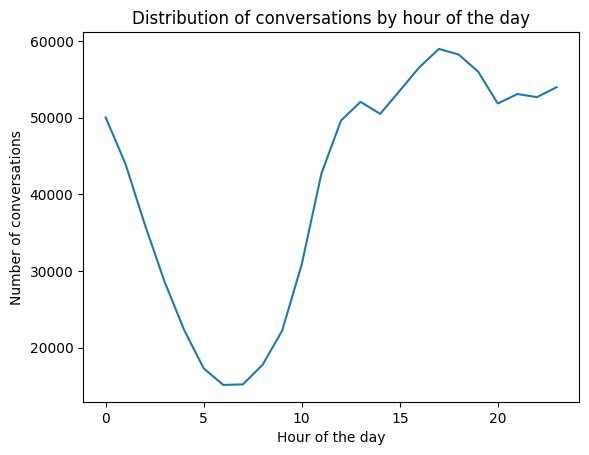

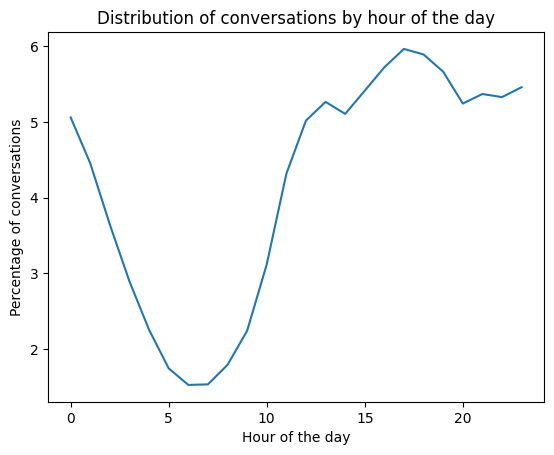

+-----------------+-----+------------------+
|hour_bin_offseted|count|        percentage|
+-----------------+-----+------------------+
|               17|58972| 5.962127569228903|
|               18|58244| 5.888526048670017|
|               16|56577| 5.719990698708941|
|               19|55997|   5.6613521246373|
|               23|53977| 5.457128125284346|
|               15|53521| 5.411026073945264|
|               21|53086| 5.367047143391534|
|               22|52682| 5.326202343520943|
|               13|52064| 5.263721931837713|
|               20|51842| 5.241277512106843|
|               14|50492|5.1047911759056115|
|                0|50026| 5.057678114668743|
|               12|49616| 5.016226708859479|
|                1|44025| 4.450971075006825|
|               11|42675| 4.314484738805593|
|                2|36028|3.6424664597466414|
|               10|30857|3.1196732416010353|
|                3|28612| 2.892701519547876|
|                4|22302| 2.254754274044343|
|         

In [17]:
# Count number of conversations group by offseted_hour_bin
hour_bin_counts = wildchat_df.groupBy("hour_bin_offseted").count().orderBy("hour_bin_offseted")

# Conver to percentage
total_conversations = wildchat_df.count()
hour_bin_counts = hour_bin_counts.withColumn("percentage", (F.col("count") / total_conversations) * 100)

# Convert to pandas for plotting
hour_bin_counts_pd = hour_bin_counts.toPandas()

# Plot the distribution of conversations by hour, by line plot
plt.plot(hour_bin_counts_pd["hour_bin_offseted"], hour_bin_counts_pd["count"])
plt.xlabel("Hour of the day")
plt.ylabel("Number of conversations")
plt.title("Distribution of conversations by hour of the day")
plt.show()

# Plot the distribution of conversations by hour, by line plot
plt.plot(hour_bin_counts_pd["hour_bin_offseted"], hour_bin_counts_pd["percentage"])
plt.xlabel("Hour of the day")
plt.ylabel("Percentage of conversations")
plt.title("Distribution of conversations by hour of the day")
plt.show()

# print the count and percentage columns of conversations, descending order
hour_bin_counts.orderBy("percentage", ascending=False).show(24)

+-----------+-----------------+-----+---------------------------+------------------+
|day_of_week|hour_bin_offseted|count|total_conversations_per_day|        percentage|
+-----------+-----------------+-----+---------------------------+------------------+
|          1|                0| 6622|                     134580|  4.92049338683311|
|          1|                1| 5516|                     134580| 4.098677366622083|
|          1|                2| 4909|                     134580|3.6476445237033737|
|          1|                3| 4196|                     134580|3.1178481200772774|
|          1|                4| 3273|                     134580| 2.432010699955417|
+-----------+-----------------+-----+---------------------------+------------------+
only showing top 5 rows



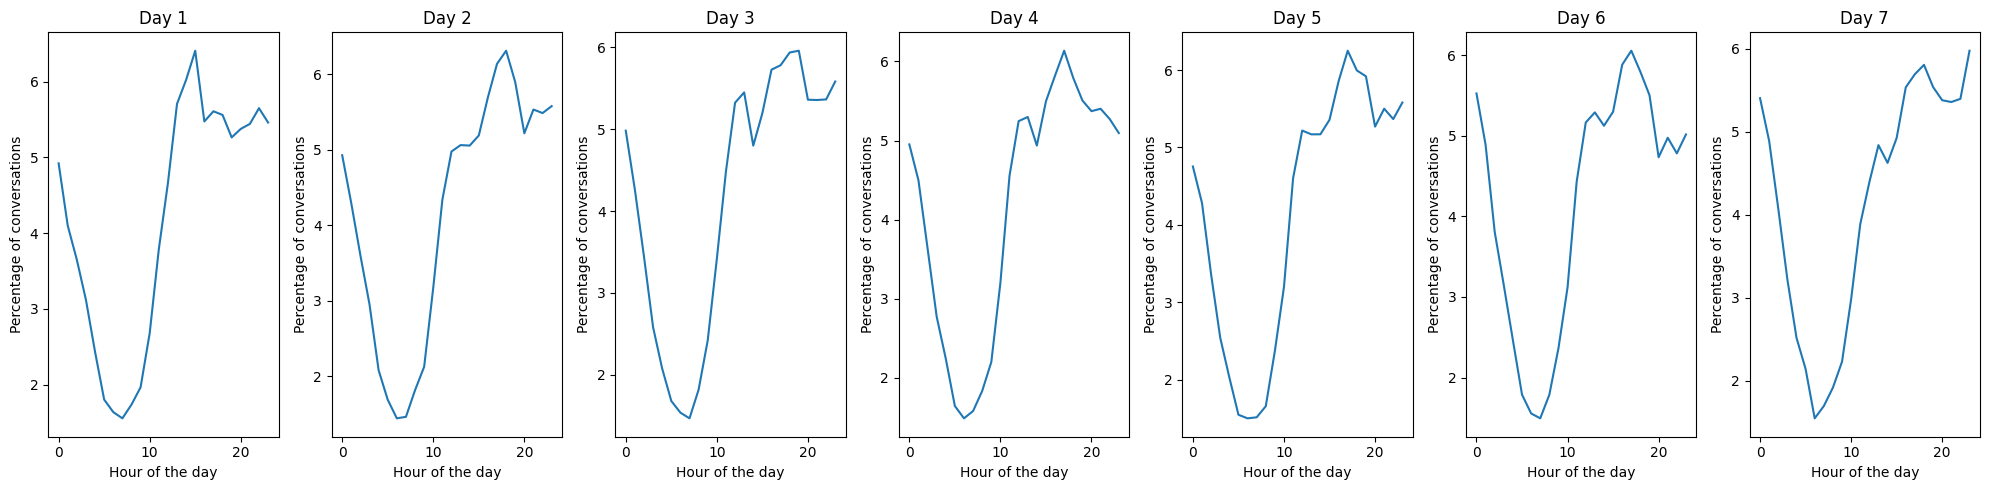

In [18]:
# Extract day of week and hour from offseted_timestamp
wildchat_df = wildchat_df.withColumn("day_of_week", F.dayofweek("offseted_timestamp"))

# Group by day and hour, count conversations
day_hour_counts = wildchat_df.groupBy("day_of_week", "hour_bin_offseted") \
	.count() \
	.orderBy("day_of_week", "hour_bin_offseted")

# Calculate percentage by days (so 7 total are needed)
total_conversations_per_day = wildchat_df.groupBy("day_of_week").agg(F.count("*").alias("total_conversations_per_day"))
day_hour_counts = day_hour_counts.join(total_conversations_per_day, "day_of_week")
day_hour_counts = day_hour_counts.withColumn("percentage", (F.col("count") / F.col("total_conversations_per_day")).cast("double") * 100)
day_hour_counts = day_hour_counts.orderBy("day_of_week", "hour_bin_offseted")

day_hour_counts.show(5)
# Convert to pandas for plotting
day_hour_pd = day_hour_counts.toPandas()

# Plot 7 subplots for each day of the week
fig, axes = plt.subplots(1, 7, figsize=(20, 5))

for i in range(1, 8):
	day_data = day_hour_pd[day_hour_pd["day_of_week"] == i]
	axes[i-1].plot(day_data["hour_bin_offseted"], day_data["percentage"])
	axes[i-1].set_title(f"Day {i}")
	axes[i-1].set_xlabel("Hour of the day")
	axes[i-1].set_ylabel("Percentage of conversations")

plt.tight_layout()
plt.show()

Weekend vs Weekday Patterns:

	- Sunday (Day 1): Peak at 3 PM (6.41%)
	- Monday (Day 2): Peak at 6 PM (6.31%)
	- Tuesday (Day 3): Peak at 7 PM (5.96%)
	- Wednesday (Day 4): Peak at 5 PM (6.14%)
	- Thursday (Day 5): Peak at 5 PM (6.25%)
	- Friday (Day 6): Peak at 5 PM (6.06%)
	- Saturday (Day 7): Peak at 11 PM (5.98%)

Key Differences:

	- Weekend patterns are distinct:
	- Sunday shows an earlier peak (3 PM)
	- Saturday shows the latest peak (11 PM)
	- Weekdays (Monday-Friday) show more consistent patterns:
	- Peaks typically occur between 5-7 PM
	- Likely correlating with after-work hours

Work Week Pattern:

	- Weekday peaks align with typical post-work hours
	- The consistency in weekday patterns suggests work/school schedules influence usage
	- The gradual shift from Monday's 6 PM peak to consistent 5 PM peaks mid-week might reflect different work/commute patterns

Weekend Characteristics:

	- Saturday's late peak (11 PM) suggests leisure-oriented usage
	- Sunday's earlier peak (3 PM) might reflect people preparing for the work week
	- Weekend patterns show more variation, likely due to flexible schedules

In [19]:
# print the busiest hour for each day (argmax)
tmp = day_hour_counts.groupBy("day_of_week").agg(F.max("count").alias("count"))
day_hour_counts.join(tmp, ["day_of_week", "count"]).select("day_of_week", "hour_bin_offseted", "percentage").orderBy('day_of_week').show()


+-----------+-----------------+-----------------+
|day_of_week|hour_bin_offseted|       percentage|
+-----------+-----------------+-----------------+
|          1|               15|6.407341358299896|
|          2|               18|6.308224647324994|
|          3|               19|5.956958826599281|
|          4|               17|6.135469253090591|
|          5|               17| 6.24916186133834|
|          6|               17|6.056726275431674|
|          7|               23|5.977810626857914|
+-----------+-----------------+-----------------+



In [20]:
!pip install pycountry_convert


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: pip install --upgrade pip


In [21]:
from pyspark.sql.functions import udf
import pycountry_convert as pc

def country_to_continent(country_name):
	try:
		# Handle special cases
		if country_name == 'United States':
			return 'North America'
		elif country_name == 'Russia':
			return 'Europe'
		elif country_name == 'The Netherlands':
			return 'Europe'
		elif country_name == 'DR Congo':
			return 'Africa'
		elif country_name == 'Kosovo':
			return 'Europe'
		elif country_name == 'Bonaire, Sint Eustatius, and Saba':
			return 'South America'
		elif country_name == 'Congo Republic':
			return 'Africa'
		elif country_name == 'St Vincent and Grenadines':
			return 'South America'
		elif country_name == 'Timor-Leste':
			return 'Asia'
		elif country_name == 'Sint Maarten':
			return 'South America'

		# Get country alpha-2 code
		country_alpha2 = pc.country_name_to_country_alpha2(country_name)
		# Get continent code
		country_continent_code = pc.country_alpha2_to_continent_code(country_alpha2)
		# Get continent name
		country_continent_name = pc.convert_continent_code_to_continent_name(country_continent_code)
		return country_continent_name
	except:
		print(f"Continent not found for {country_name}")
		return None

# Test the function
print(country_to_continent("United States"))  # North America
print(country_to_continent("Russia"))  # Europe
print(country_to_continent("India"))  # Asia
print(country_to_continent("Narnia"))  # None
print(country_to_continent("Australia"))  # Oceania
print(country_to_continent("Japan"))  # Asia

# Create UDF
country_to_continent_udf = udf(country_to_continent, StringType())

North America
Europe
Asia
Continent not found for Narnia
None
Oceania
Asia


+-------------+------+------------------+
|    continent| count|        percentage|
+-------------+------+------------------+
|       Europe|347641|35.146849187653544|
|         Asia|301783|30.510559998382387|
|North America|244522|24.721416222664818|
|       Africa| 48470| 4.900364974573101|
|South America| 31511|3.1857932889162983|
|      Oceania| 15183|1.5350163278098492|
+-------------+------+------------------+



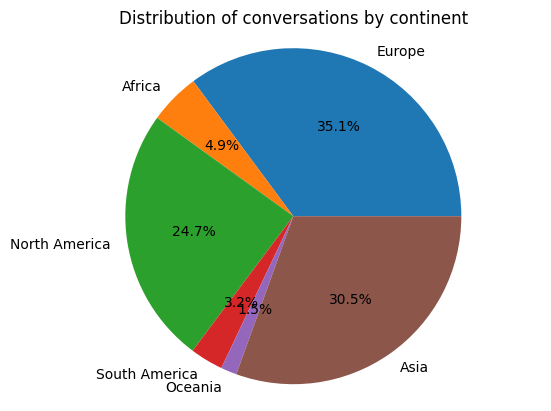

In [23]:
# Add continent column
wildchat_df = wildchat_df.withColumn("continent", country_to_continent_udf(col("country")))

# Show distribution of conversations by continent
continent_counts = wildchat_df.groupBy("continent").count()
total = wildchat_df.count()
continent_counts = continent_counts.withColumn("percentage", (col("count") / total) * 100)
continent_counts.orderBy("count", ascending=False).show()

# Convert to pandas for plotting
continent_counts_pd = continent_counts.toPandas()

# Plot the distribution of conversations by continent by pie chart
plt.pie(continent_counts_pd["count"], labels=continent_counts_pd["continent"], autopct='%1.1f%%')
plt.axis('equal')
plt.title("Distribution of conversations by continent")
plt.show()


+---------+-----------------+-----+---------------------------------+------------------+
|continent|hour_bin_offseted|count|total_conversations_per_continent|        percentage|
+---------+-----------------+-----+---------------------------------+------------------+
|   Africa|                0| 1700|                            48470| 3.507324118011141|
|   Africa|                1| 1558|                            48470| 3.214359397565504|
|   Africa|                2| 1373|                            48470|2.8326800082525274|
|   Africa|                3| 1087|                            48470| 2.242624303693006|
|   Africa|                4|  836|                            48470|1.7247782133278315|
+---------+-----------------+-----+---------------------------------+------------------+
only showing top 5 rows



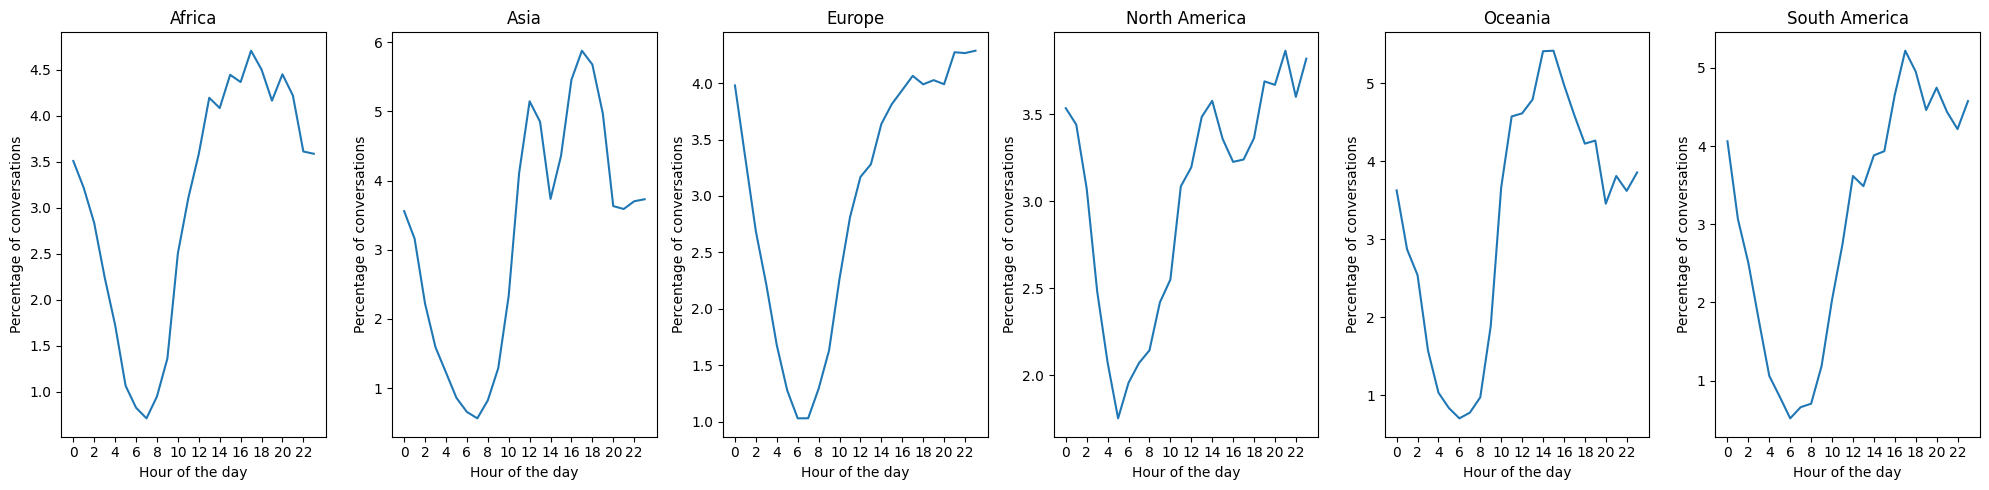

In [29]:
# Group by continent and hour, count conversations, exclude weekend (day 2 to 6)
continent_hour_counts = wildchat_df.filter(col("day_of_week").between(2, 6)).groupBy("continent", "hour_bin_offseted")\
	.count() \
	.orderBy("continent", "hour_bin_offseted")

# Calculate percentage by continent
total_conversations_per_continent = wildchat_df.groupBy("continent").agg(F.count("*").alias("total_conversations_per_continent"))
continent_hour_counts = continent_hour_counts.join(total_conversations_per_continent, "continent")
continent_hour_counts = continent_hour_counts.withColumn("percentage", (F.col("count") / F.col("total_conversations_per_continent")).cast("double") * 100)
continent_hour_counts = continent_hour_counts.orderBy("continent", "hour_bin_offseted")

continent_hour_counts.show(5)
# Convert to pandas for plotting
day_hour_pd = continent_hour_counts.toPandas()

# Plot 6 subplots for each continent
fig, axes = plt.subplots(1, 6, figsize=(20, 5))

for i, continent in enumerate(day_hour_pd["continent"].unique()):
	continent_data = day_hour_pd[day_hour_pd["continent"] == continent]
	axes[i].plot(continent_data["hour_bin_offseted"], continent_data["percentage"])
	axes[i].set_title(continent)
	axes[i].set_xlabel("Hour of the day")
	axes[i].set_ylabel("Percentage of conversations")
	# set xtick
	axes[i].set_xticks(range(0, 24, 2))

plt.tight_layout()
plt.show()


In [31]:
# print the busiest hour for each continent (argmax)
tmp = continent_hour_counts.groupBy("continent").agg(F.max("count").alias("count"))
continent_hour_counts.join(tmp, ["continent", "count"]).select("continent", "hour_bin_offseted", "percentage").orderBy('continent').show()


+-------------+-----------------+------------------+
|    continent|hour_bin_offseted|        percentage|
+-------------+-----------------+------------------+
|       Africa|               17| 4.706003713637301|
|         Asia|               17| 5.876739246412157|
|       Europe|               23| 4.287468969425356|
|North America|               21|3.8663187770425567|
|      Oceania|               15| 5.420536125930317|
|South America|               17| 5.220399225667228|
+-------------+-----------------+------------------+



### Discussion:

#### Key Cross-Regional Insights:

	Morning Engagement:
	• Highest: North America (2.5%)
	• Lowest: Asia/South America (~1%)
	Evening Behavior:
	• Late sustainers: Europe/North America
	• Early decliners: Asia/Oceania
	• Mid-range: Africa/South America
	Pattern Volatility:
	• Most volatile: Asia
	• Most stable: North America
	• Moderate: Others


* **Cultural Impact:**
    * Western regions (NA/Europe): More individualistic patterns.
    * Southern Hemisphere: Stronger community-based patterns.
    * Asia/Africa: More traditional rhythms.
* **Work Culture:**
    * NA/Europe: Flexible, extended hours.
    * Oceania: Structured, daylight-focused.
    * Others: Traditional business hours.
* **Social Patterns:**
    * Europe: Late social culture.
    * NA: Extended activity period.
    * Others: More traditional evening patterns.
* **Technology Adoption:**
    * NA/Europe: Consistent digital engagement.
    * Others: More purpose-driven usage patterns.

#### The "Double Peak" Pattern in Asia:

Morning Peak (around 12:00)

	- Likely represents late morning work productivity
	- Coincides with pre-lunch business hours
	- Common time for meetings and business activities in many Asian countries

Significant Drop (12:00-14:00)

	- Strongly correlates with lunch break customs in many Asian countries:
		- China: "午休" (wǔxiū) culture - extended lunch break with possible nap
		- Japan: Dedicated lunch hour is strictly observed
		- South Korea: Traditional lunch break culture
		- Southeast Asia: Common practice of longer lunch breaks due to heat
	- Cultural factors contributing to this pattern:
		- Many Asian businesses close completely during lunch
		- Common practice to return home for lunch in some countries
		- Mid-day heat avoidance in Southeast Asian countries
		 -Traditional siesta-like practices in some regions

Afternoon Recovery (14:00 onwards)

	- Sharp increase after lunch period
	- Builds toward the strongest peak of the day
	- Reflects return to work with renewed energy
	- Might indicate:
		- Post-rest productivity boost
		- Cooler afternoon temperatures
		- Business interactions with Western markets beginning

This pattern is distinct from other regions and reveals:

	- Stronger adherence to collective break times
	- More structured work-day rhythms
	- Cultural respect for meal times
	- Possible influence of climate on daily routines
	- Traditional practices still influencing modern work patterns

**NORTH AMERICA**

* **Smoothest overall curve:**
    * Diverse time zones (PST to EST) smooth out national trends.
    * Multiple metropolitan centers distribute activity.
    * Less synchronized national patterns.
    * Mixed work cultures across regions.
* **Highest morning baseline (2.5%):**
    * Early-rising business culture on the East Coast while the West Coast remains active.
    * Influence of 24/7 business operations.
    * Strong morning productivity culture.
* **Gradual, consistent rise:**
    * Staggered lunch breaks and flexible work schedules.
    * Mix of work and personal usage.
    * Less rigid break times.
* **Late peak (23:00):**
    * Strong entertainment/leisure culture and late-night internet usage habits.
    * Work-from-home influence.
    * Extended business hours.


**EUROPE**

* **Most gradual daily increase:**
    * Diverse work cultures and flexible work arrangements across countries.
    * Mixed morning/evening preferences.
    * Less rigid social schedules.
* **Extended evening plateau:**
    * Later dinner times, especially in Southern Europe.
    * Strong after-work social culture.
    * Extended business hours.
    * Work-life blend rather than a strict balance.
* **Late peak (23:00):**
    * Evening leisure culture and late dining habits.
    * Entertainment consumption patterns.
    * Digital-first lifestyle.
* **Higher sustained night activity:**
    * Active nightlife culture.
    * Less strict morning schedules.


**SOUTH AMERICA**

* **Deep morning trough (~1%):**
    * Influence of a strong night culture and a later start to the business day.
    * Traditional morning patterns.
    * Clear rest periods.
* **Sharp recovery post-trough:**
    * Concentrated work hours.
    * Strong afternoon business culture.
    * Post-siesta productivity.
    * Clear transition periods.
* **Multiple evening peaks:**
    * Mixed usage patterns for social media, family time, work, and entertainment.
* **Sustained evening activity:**
    * Strong social culture and late dinner habits.
    * Family-oriented evening time.
    * Extended day pattern.


**OCEANIA**

* **Earlier peak (15:00):**
    * Alignment with business hours and an early dinner culture.
    * Influence of an outdoor lifestyle.
    * Work-day focused usage.
* **Wide morning trough:**
    * Leisurely mornings with a preference for outdoor activities.
    * Relaxed morning culture.
    * Less urgency in the mornings.
* **Smooth afternoon rise:**
    * Consistent work patterns and regular business hours.
    * Structured daily rhythm.
    * Clear progression of activities.
* **Earlier evening decline:**
    * Early dinner culture and family-focused evenings.
    * Outdoor lifestyle.
    * Morning-oriented society.


**AFRICA**

* **Classic U-shape pattern:**
    * Traditional day/night rhythm influenced by solar time.
    * Natural activity patterns.
    * Clear collective behaviors.
* **Sharp morning decline:**
    * Quick transition to work.
    * Strong morning routines.
    * Synchronized behaviors.
    * Clear boundaries between activities.
* **Deep mid-day trough:**
    * Heat avoidance and traditional break patterns.
    * Potential religious and cultural influences.
* **Earlier evening wrap-up:**
    * Family-oriented culture and traditional evening patterns.
    * Earlier rest periods.
    * Community-based activities.

# Question 6: How does user retention vary by country?
- WildChat: Calculate percentage of repeat users for top countries

In [33]:
user_counts = wildchat_df.groupBy("hashed_ip").agg(F.count("*").alias("conv_count"))

# Create a binary column for repeat users or not (count > 3)
user_counts = user_counts.withColumn(
	"repeat_user",
	F.when(F.col("conv_count") > 3, 1).otherwise(0)
)

# Find % percentage of conversation from countries
# Group by country and count conversations
country_counts = wildchat_df.groupBy("country").count()
total = wildchat_df.count()

# Calculate percentage
country_counts = country_counts.withColumn("percentage", (F.col("count") / total) * 100)
country_counts = country_counts.orderBy("count", ascending=False)
# Calculate cumulative percentage
country_counts = country_counts.withColumn("cumulative_percentage", F.sum("percentage").over(Window.orderBy(F.desc("percentage"))))
country_counts.show(20)

25/01/07 17:52:54 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/01/07 17:52:54 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/01/07 17:52:54 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/01/07 17:52:54 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/01/07 17:52:54 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/01/07 17:52:55 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/01/07 1

+---------------+------+------------------+---------------------+
|        country| count|        percentage|cumulative_percentage|
+---------------+------+------------------+---------------------+
|  United States|212910|21.525411733780874|   21.525411733780874|
|         Russia|146971|14.858913568763837|    36.38432530254471|
|          China|103325|10.446259768883138|    46.83058507142785|
|      Hong Kong| 48005|  4.85335301432601|    51.68393808575386|
| United Kingdom| 37034| 3.744174055464003|    55.42811214121786|
|        Germany| 35704|3.6097097390583457|   59.037821880276205|
|         France| 33363| 3.373032321986432|   62.410854202262634|
|         Canada| 19096|1.9306245008138627|    64.34147870307649|
|          Japan| 18905|1.9113142117661333|    66.25279291484263|
|          India| 17861| 1.805764778437181|    68.05855769327981|
|          Italy| 16488|1.6669531194710394|    69.72551081275085|
|         Brazil| 15810|1.5984066484010877|    71.32391746115194|
|         

=> TOP 7 COUNTRIES:
- United States
- Russia
- China
- Hong Kong
- United Kingdom
- Germany
- France

In [38]:
top_countries = country_counts.select("country").limit(7).collect()
# convert to list
top_countries = [row["country"] for row in top_countries]

# Filter out countries different from the top 7
wildchat_top_7_df = wildchat_df.filter(F.col("country").isin(top_countries))

# Calculate the percentage of repeated users for each country
# Group by country and repeat_user, count conversations
# join user_counts with wildchat_top_7_df
wildchat_top_7_df = wildchat_top_7_df.join(user_counts, "hashed_ip")
country_repeat_counts = wildchat_top_7_df.groupBy("country", "repeat_user").count()

# Calculate total number of users per country
country_repeat_counts = country_repeat_counts.withColumn("total_users", F.sum("count").over(Window.partitionBy("country")))

# Calculate percentage
country_repeat_counts = country_repeat_counts.withColumn("percentage", (F.col("count") / F.col("total_users")).cast("double") * 100)

# Filter out repeat users
repeat_users = country_repeat_counts.filter(F.col("repeat_user") == 1)
repeat_users.show()


+--------------+-----------+------+-----------+-----------------+
|       country|repeat_user| count|total_users|       percentage|
+--------------+-----------+------+-----------+-----------------+
|         China|          1| 71173|     103325|68.88265182676022|
|        France|          1| 27612|      33363|82.76234151605072|
|       Germany|          1| 31363|      35704|87.84169840914183|
|     Hong Kong|          1| 39343|      48005|81.95604624518279|
|        Russia|          1|122543|     146971|83.37903395908036|
|United Kingdom|          1| 32940|      37034|88.94529351406815|
| United States|          1|189935|     212910|89.20905546944718|
+--------------+-----------+------+-----------+-----------------+



In [39]:
# Calculate percentage of repeat users for the whole dataset
total_users = user_counts.count()
repeat_users = user_counts.filter(F.col("repeat_user") == 1).count()

repeat_percentage = (repeat_users / total_users) * 100
print(f"Percentage of repeat users for the whole dataset: {repeat_percentage:.2f}%")

Percentage of repeat users for the whole dataset: 20.55%


# Question 7: Do engagement patterns differ between desktop and mobile users?
- WildChat: Use header info to classify desktop vs mobile, compare metrics like turns per conversation and time between conversations

In [7]:
# Create a column to assign device type based on user-agent (desktop vs mobile)
from pyspark.sql.functions import when

# Create a column to assign device type based on user-agent (desktop vs mobile)
wildchat_df = wildchat_df.withColumn(
	"device_type",
	when(
		F.lower(F.col("header.user-agent")).like("%mobile%"),
		"mobile"
	).otherwise("desktop")
)

# Calculate average turn per conversation for each device type
avg_turns = wildchat_df.groupBy("device_type").agg(F.avg("turn").alias("avg_turns"))

# Calculate std of turn per conversation for each device type
std_turns = wildchat_df.groupBy("device_type").agg(F.stddev("turn").alias("std_turns"))

# Calculate average turn per conversation for the whole dataset
avg_turns_all = wildchat_df.agg(F.avg("turn")).collect()[0][0]

# Calculate total number of conversations per device type and percentage
total_conversations = wildchat_df.count()
device_counts = wildchat_df.groupBy("device_type").count()
device_counts = device_counts.withColumn("percentage", (F.col("count") / total_conversations) * 100)

In [8]:
avg_turns.show()
std_turns.show()
print(f"Average turns per conversation for the whole dataset: {avg_turns_all:.2f}")

device_counts.show()

+-----------+-----------------+
|device_type|        avg_turns|
+-----------+-----------------+
|    desktop|2.552158499981472|
|     mobile|2.429517319202133|
+-----------+-----------------+



+-----------+------------------+
|device_type|         std_turns|
+-----------+------------------+
|    desktop|3.7218159213695636|
|     mobile|3.2153959746786125|
+-----------+------------------+

Average turns per conversation for the whole dataset: 2.53


+-----------+------+-----------------+
|device_type| count|       percentage|
+-----------+------+-----------------+
|    desktop|809590|81.74605097882412|
|     mobile|180782|18.25394902117588|
+-----------+------+-----------------+



In [9]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
import numpy as np
from pyspark.sql import DataFrame

def check_normality_visual(spark_df: DataFrame, column: str, sample_size=10000):
    """
    Visual normality check for PySpark DataFrame
    """
    # Efficient sampling from spark dataframe
    if spark_df.count() > sample_size:
        sample_df = spark_df.select(column).sample(False, fraction=sample_size/spark_df.count(), seed=42)
    else:
        sample_df = spark_df.select(column)
    
    # Convert to pandas for plotting (more efficient than collecting all data)
    pandas_sample = sample_df.toPandas()[column]
    
    # Create subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Histogram with KDE
    sns.histplot(data=pandas_sample, ax=ax1, kde=True)
    ax1.set_title('Distribution Plot')
    
    # Q-Q plot
    stats.probplot(pandas_sample, dist="norm", plot=ax2)
    ax2.set_title('Q-Q Plot')
    
    plt.tight_layout()
    plt.show()

# For more efficient descriptive statistics directly from Spark
def get_spark_stats(spark_df: DataFrame, column: str):
    """
    Get basic statistics using Spark's built-in functions
    """
    from pyspark.sql.functions import mean, stddev, count, skewness, kurtosis
    
    stats_df = spark_df.select(
        mean(column).alias('mean'),
        stddev(column).alias('std'),
        count(column).alias('count'),
        skewness(column).alias('skewness'),
        kurtosis(column).alias('kurtosis')
    )
    
    # Collect only one row of statistics
    stats = stats_df.collect()[0]
    
    print(f"Full dataset statistics (computed with Spark):")
    print(f"Count: {stats['count']:,}")
    print(f"Mean: {stats['mean']:.3f}")
    print(f"Std Dev: {stats['std']:.3f}")
    print(f"Skewness: {stats['skewness']:.3f}")
    print(f"Kurtosis: {stats['kurtosis']:.3f}")

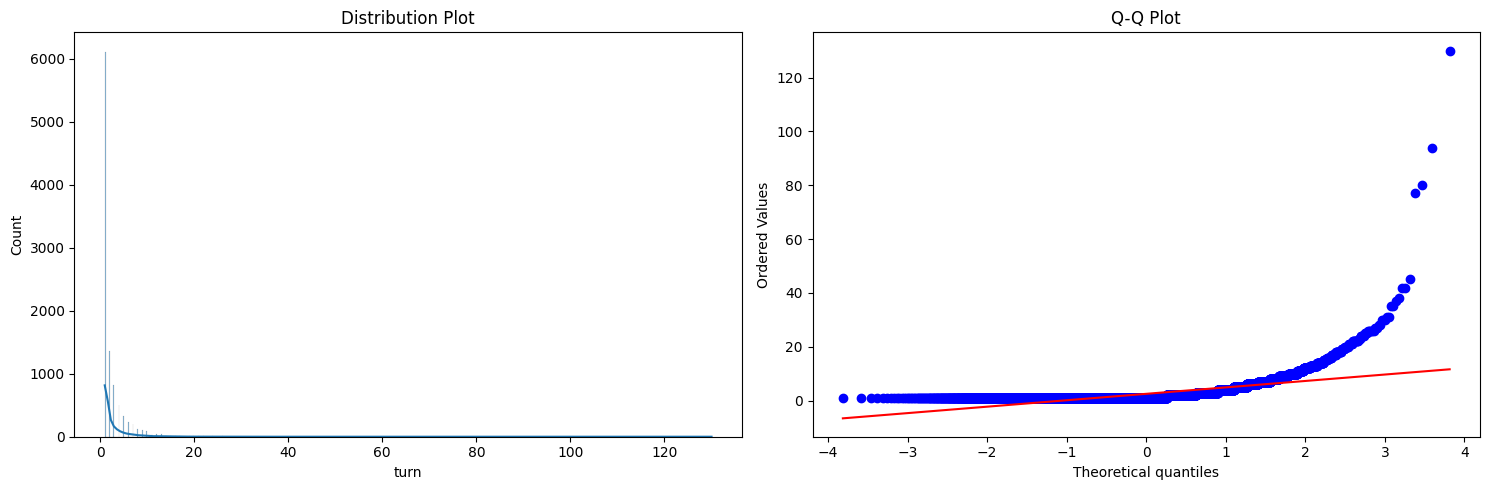

Full dataset statistics (computed with Spark):
Count: 809,590
Mean: 2.552
Std Dev: 3.722
Skewness: 8.252
Kurtosis: 172.675


In [10]:
check_normality_visual(wildchat_df.filter(F.col("device_type") == "desktop"), "turn")

get_spark_stats(wildchat_df.filter(F.col("device_type") == "desktop"), "turn")


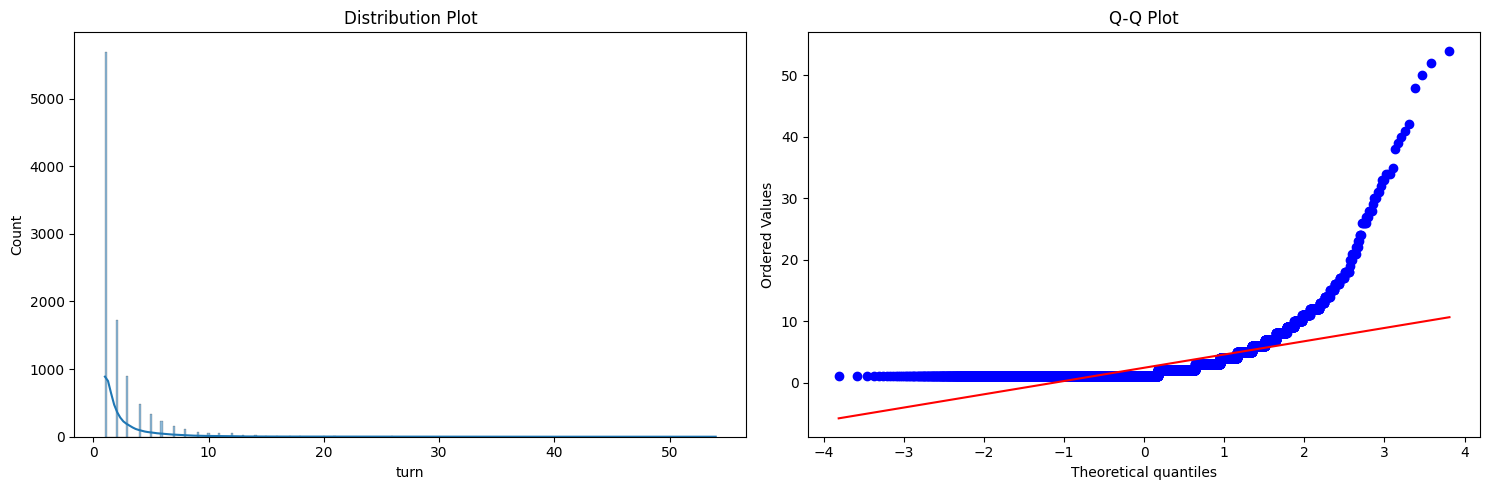

Full dataset statistics (computed with Spark):
Count: 180,782
Mean: 2.430
Std Dev: 3.215
Skewness: 6.764
Kurtosis: 94.542


In [11]:
check_normality_visual(wildchat_df.filter(F.col("device_type") == "mobile"), "turn")

get_spark_stats(wildchat_df.filter(F.col("device_type") == "mobile"), "turn")


In [12]:
from pyspark.sql import functions as F
from pyspark.sql.window import Window

def compare_devices(spark_df, turn_column='turn', device_column='device_type', sample_size_per_group=100000):
    """
    Performs Mann-Whitney U test with stratified sampling to handle class imbalance
    """
    # Sample equally from each device type
    desktop_sample = (spark_df
                     .filter(F.col(device_column) == 'desktop')
                     .sample(False, fraction=min(1.0, sample_size_per_group/809590), seed=42))
    
    mobile_sample = (spark_df
                    .filter(F.col(device_column) == 'mobile')
                    .sample(False, fraction=min(1.0, sample_size_per_group/180782), seed=42))
    
    # Get actual sample sizes
    desktop_count = desktop_sample.count()
    mobile_count = mobile_sample.count()
    
    print(f"\nSample sizes:")
    print(f"Desktop: {desktop_count:,}")
    print(f"Mobile: {mobile_count:,}")
    
    # Collect values for statistical testing
    desktop_data = np.array(desktop_sample.select(turn_column)
                          .rdd.flatMap(lambda x: x).collect())
    mobile_data = np.array(mobile_sample.select(turn_column)
                         .rdd.flatMap(lambda x: x).collect())
    
    # Perform Mann-Whitney U test
    statistic, p_value = stats.mannwhitneyu(desktop_data, mobile_data, 
                                          alternative='two-sided')
    
    # Calculate effect size
    z_score = stats.norm.ppf(p_value/2)
    effect_size = abs(z_score) / np.sqrt(desktop_count + mobile_count)
    
    print(f"\nMann-Whitney U Test Results:")
    print(f"p-value: {p_value:.10f}")
    print(f"Effect size (r): {effect_size:.3f}")
    print(f"Effect size interpretation: {interpret_effect_size(effect_size)}")
    
    # Calculate confidence intervals for median difference
    conf_level = 0.95
    diff_ci = stats.bootstrap((desktop_data, mobile_data), 
                            lambda x, y: np.median(x) - np.median(y),
                            confidence_level=conf_level)
    
    print(f"\n{conf_level*100}% Confidence Interval for Median Difference:")
    print(f"({diff_ci.confidence_interval.low:.2f}, {diff_ci.confidence_interval.high:.2f})")
    
def get_detailed_stats(spark_df, turn_column='turn', device_column='device_type'):
    """
    Calculates descriptive statistics using Spark operations
    """
    # Calculate percentiles and stats for each device type
    stats_df = spark_df.groupBy(device_column).agg(
        F.count(turn_column).alias('count'),
        F.avg(turn_column).alias('mean'),
        F.expr(f'percentile_approx({turn_column}, array(0.25, 0.5, 0.75), 10000)').alias('percentiles'),
        F.stddev(turn_column).alias('std_dev')
    )
    
    # Collect results (small result set, safe to collect)
    results = stats_df.collect()
    
    for row in results:
        print(f"\n{row[device_column].upper()} Statistics:")
        print(f"Count: {row['count']:,}")
        print(f"Mean: {row['mean']:.2f}")
        print(f"Standard Deviation: {row['std_dev']:.2f}")
        print(f"25th percentile: {row['percentiles'][0]:.2f}")
        print(f"Median: {row['percentiles'][1]:.2f}")
        print(f"75th percentile: {row['percentiles'][2]:.2f}")
        print(f"IQR: {(row['percentiles'][2] - row['percentiles'][0]):.2f}")

# Additional function for effect size interpretation
def interpret_effect_size(effect_size):
    if effect_size < 0.1:
        return "Negligible effect"
    elif effect_size < 0.3:
        return "Small effect"
    elif effect_size < 0.5:
        return "Medium effect"
    else:
        return "Large effect"
    
# Additional function for power analysis
def calculate_required_sample_size(effect_size=0.3, power=0.8, alpha=0.05):
    """
    Calculate required sample size per group for Mann-Whitney U test
    """
    # Approximation using normal distribution
    z_alpha = stats.norm.ppf(1 - alpha/2)
    z_beta = stats.norm.ppf(power)
    
    n = ((z_alpha + z_beta)**2 * 2) / (3 * effect_size**2)
    return int(np.ceil(n))

In [13]:
# Run the analyses
min_sample_size = calculate_required_sample_size(effect_size=0.3)
print(f"Minimum required sample size per group: {min_sample_size:,}")

get_detailed_stats(wildchat_df)
compare_devices(wildchat_df, turn_column='turn', device_column='device_type', sample_size_per_group=1000)

Minimum required sample size per group: 59



DESKTOP Statistics:
Count: 809,590
Mean: 2.55
Standard Deviation: 3.72
25th percentile: 1.00
Median: 1.00
75th percentile: 3.00
IQR: 2.00

MOBILE Statistics:
Count: 180,782
Mean: 2.43
Standard Deviation: 3.22
25th percentile: 1.00
Median: 1.00
75th percentile: 3.00
IQR: 2.00

Sample sizes:
Desktop: 985
Mobile: 1,045



Mann-Whitney U Test Results:
p-value: 0.1275991713
Effect size (r): 0.034
Effect size interpretation: Negligible effect

95.0% Confidence Interval for Median Difference:
(nan, nan)


/Users/lgk1910/anaconda3/envs/sl/lib/python3.10/site-packages/scipy/stats/_resampling.py:147: RuntimeWarning: invalid value encountered in scalar divide
  a_hat = 1/6 * sum(nums) / sum(dens)**(3/2)
/Users/lgk1910/anaconda3/envs/sl/lib/python3.10/site-packages/scipy/stats/_resampling.py:100: DegenerateDataWarning: The BCa confidence interval cannot be calculated. This problem is known to occur when the distribution is degenerate or the statistic is np.min.
  warnings.warn(DegenerateDataWarning(msg))


# Question 8: How do engagement metrics evolve over a user's lifetime?
- WildChat: For users with many conversations, plot engagement metrics over time to spot trends


In [30]:
# filter out rows where 'country' is null
wildchat_df = wildchat_df.filter(F.col("country").isNotNull())

In [31]:
# open the parquet file
country_state_df = spark.read.parquet("../country_state_timezone.parquet")
country_state_df.count() # 2433

# join condition to handle cases when 'state' is null
wildchat_df = wildchat_df.join(
    country_state_df,
    (
        (wildchat_df["country"] == country_state_df["ccountry"]) &
        (
            (wildchat_df["state"] == country_state_df["sstate"]) |
            (wildchat_df["state"].isNull() & country_state_df["sstate"].isNull())
        )
    ),
    "left"
)


# Select the required columns and filter to show rows where 'timezone' is null, supposed to be 1262 (only a small fraction)
wildchat_df.select("country", "state", "timezone").filter(F.col("timezone").isNull()).count() # 1262

# drop ccountry and sstate columns
wildchat_df = wildchat_df.drop("ccountry", "sstate")
wildchat_df.columns

# Shift the timestamp by adding the GMT offset hours
wildchat_df = wildchat_df.withColumn(
	"offseted_timestamp",
	(F.unix_timestamp("timestamp") + F.col("gmt_offset.hours") * 3600 + F.col("gmt_offset.minutes") * 60).cast("timestamp")
)

wildchat_df.select("timestamp", "gmt_offset", "offseted_timestamp").show(5)

AnalysisException: [AMBIGUOUS_REFERENCE] Reference `timezone` is ambiguous, could be: [`timezone`, `timezone`].

In [9]:
user_counts = wildchat_df.groupBy("hashed_ip").agg(F.count("*").alias("conv_count"))

# Find earliest date of usage for each user
# Group by hashed_ip and find the minimum timestamp
earliest_date = wildchat_df.groupBy("hashed_ip").agg(F.min("timestamp").alias("earliest_date"))

# Find latest date of usage for each user
# Group by hashed_ip and find the maximum timestamp
latest_date = wildchat_df.groupBy("hashed_ip").agg(F.max("timestamp").alias("latest_date"))

# Join with user_counts
user_counts = user_counts.join(earliest_date, "hashed_ip").join(latest_date, "hashed_ip")

# Find avg number of conversations per day for each user
# Calculate the number of days between earliest and latest date
user_counts = user_counts.withColumn("num_days", F.datediff("latest_date", "earliest_date"))
# Calculate avg number of conversations per day
user_counts = user_counts.withColumn("avg_conv_per_day", F.col("conv_count") / F.col("num_days"))

# # Calculate the 90th percentile of avg_conv_per_day
# percentile_90 = wildchat_df.approxQuantile("avg_conv_per_day", [0.90], 0.001)[0]
# print(f'90th percentile: {percentile_90}')

# Filter out users with avg_conv_per_day > 1
repeat_users = user_counts.filter(F.col("avg_conv_per_day") > 2)
repeat_users.count()

# Count the number of conversations after filtering
repeat_users.join(wildchat_df, "hashed_ip").count() # 406092

405908

In [ ]:
repeat_users.orderBy("avg_conv_per_day", ascending=False).show(5)

# Remove outliers, which are users that have significantly more/fewer conversations 
# Calculate the 90th percentile of avg_conv_per_day
percentile_90 = repeat_users.approxQuantile("avg_conv_per_day", [0.90], 0.001)[0]
print(f'90th percentile: {percentile_90}')
# Calculate the 10th percentile of avg_conv_per_day
percentile_10 = repeat_users.approxQuantile("avg_conv_per_day", [0.10], 0.001)[0]
print(f'10th percentile: {percentile_10}')

# # Filter out users with avg_conv_per_day outside the 10th and 90th percentile
# repeat_users_filtered = repeat_users.filter(F.col("avg_conv_per_day").between(percentile_10, percentile_90))

# Filter out users with avg_conv_per_day less than 90th percentile
repeat_users_filtered = repeat_users.filter(F.col("avg_conv_per_day") < percentile_90)

# Calculate the number of users after filtering
num_repeat_users_filtered = repeat_users_filtered.count() 
print(f"Number of repeat users after filtering: {num_repeat_users_filtered:,}")

repeat_users_filtered.orderBy("avg_conv_per_day", ascending=False).show(5)
repeat_users_filtered.orderBy("avg_conv_per_day", ascending=True).show(5)

+--------------------+----------+-------------------+-------------------+--------+-----------------+
|           hashed_ip|conv_count|      earliest_date|        latest_date|num_days| avg_conv_per_day|
+--------------------+----------+-------------------+-------------------+--------+-----------------+
|25fe0280393351ba0...|      6774|2023-10-29 09:15:56|2023-10-30 12:15:00|       1|           6774.0|
|5513c5008a7ca449d...|      2810|2023-07-17 13:53:49|2023-07-19 10:19:10|       2|           1405.0|
|e2f634aeb24856b2d...|      1934|2023-06-22 11:19:22|2023-06-25 00:16:57|       3|644.6666666666666|
|9fe38a6165f52c3c7...|      2413|2023-06-27 11:26:02|2023-07-01 07:01:16|       4|           603.25|
|df16bc9b9c7d893e9...|       595|2023-07-27 08:55:08|2023-07-28 23:41:10|       1|            595.0|
+--------------------+----------+-------------------+-------------------+--------+-----------------+
only showing top 5 rows



90th percentile: 15.0


10th percentile: 2.6666666666666665


Number of repeat users after filtering: 9,213


+--------------------+----------+-------------------+-------------------+--------+------------------+
|           hashed_ip|conv_count|      earliest_date|        latest_date|num_days|  avg_conv_per_day|
+--------------------+----------+-------------------+-------------------+--------+------------------+
|15a4597fe07f49419...|       837|2023-05-25 09:39:44|2023-07-20 10:52:12|      56|14.946428571428571|
|9ef245f7d286986aa...|       208|2024-01-31 09:26:37|2024-02-14 15:53:40|      14|14.857142857142858|
|9d9f230c2533fb238...|      2154|2023-04-09 03:42:45|2023-09-02 08:19:53|     146|14.753424657534246|
|902e801c5d3a57d55...|        59|2023-04-28 18:16:47|2023-05-02 06:50:06|       4|             14.75|
|f483c1e4b4566d09e...|       177|2024-02-14 02:24:07|2024-02-26 06:02:33|      12|             14.75|
+--------------------+----------+-------------------+-------------------+--------+------------------+
only showing top 5 rows



+--------------------+----------+-------------------+-------------------+--------+------------------+
|           hashed_ip|conv_count|      earliest_date|        latest_date|num_days|  avg_conv_per_day|
+--------------------+----------+-------------------+-------------------+--------+------------------+
|b1572858f62dd8cab...|       467|2023-08-07 19:53:49|2024-03-27 21:28:05|     233| 2.004291845493562|
|86b37224e09e7a383...|       141|2023-06-06 18:22:36|2023-08-15 12:02:04|      70|2.0142857142857142|
|c1e8219a2cc3a55ae...|        77|2024-02-19 15:07:09|2024-03-28 05:07:07|      38| 2.026315789473684|
|6cbfef23721dd0278...|       306|2023-06-19 13:22:07|2023-11-17 08:35:16|     151|2.0264900662251657|
|833255e1c754b51cc...|       142|2023-04-10 15:40:40|2023-06-19 18:02:01|      70|2.0285714285714285|
+--------------------+----------+-------------------+-------------------+--------+------------------+
only showing top 5 rows



In [11]:
# Count the number of conversations after filtering
repeat_users_filtered.join(wildchat_df, "hashed_ip").count() # 195969 if not filtering 10th percentile, 172447 if filtering 10th percentile

195824

In [12]:
# Extract the day of the week from the timestamp of those users
# Join with the original dataframe
repeat_users_df = wildchat_df.join(repeat_users_filtered, "hashed_ip")

# Extract day of the week
repeat_users_df = repeat_users_df.withColumn("day_of_week", F.dayofweek("timestamp"))

In [13]:
# Group by day of the week and count the number of conversations
day_counts = repeat_users_df.groupBy("day_of_week").count().orderBy("day_of_week")

# Calculate percentage
total_conversations = day_counts.agg(F.sum("count")).collect()[0][0]
day_counts = day_counts.withColumn("percentage", (F.col("count") / total_conversations) * 100)
day_counts.show()

+-----------+-----+------------------+
|day_of_week|count|        percentage|
+-----------+-----+------------------+
|          1|27486|14.036073208595473|
|          2|28312|14.457880545796225|
|          3|27749| 14.17037748182041|
|          4|29296|14.960372579459106|
|          5|28408|14.506904158836505|
|          6|28196| 14.39864368003922|
|          7|26377|13.469748345453059|
+-----------+-----+------------------+



+-----------+-----------------+-----+---------------------------+------------------+
|day_of_week|hour_bin_offseted|count|total_conversations_per_day|        percentage|
+-----------+-----------------+-----+---------------------------+------------------+
|          1|                0| 1527|                      27130| 5.628455584224106|
|          1|                1| 1278|                      27130| 4.710652414301511|
|          1|                2| 1216|                      27130| 4.482123110947291|
|          1|                3| 1038|                      27130|3.8260228529303353|
|          1|                4|  690|                      27130|2.5433099889421307|
+-----------+-----------------+-----+---------------------------+------------------+
only showing top 5 rows



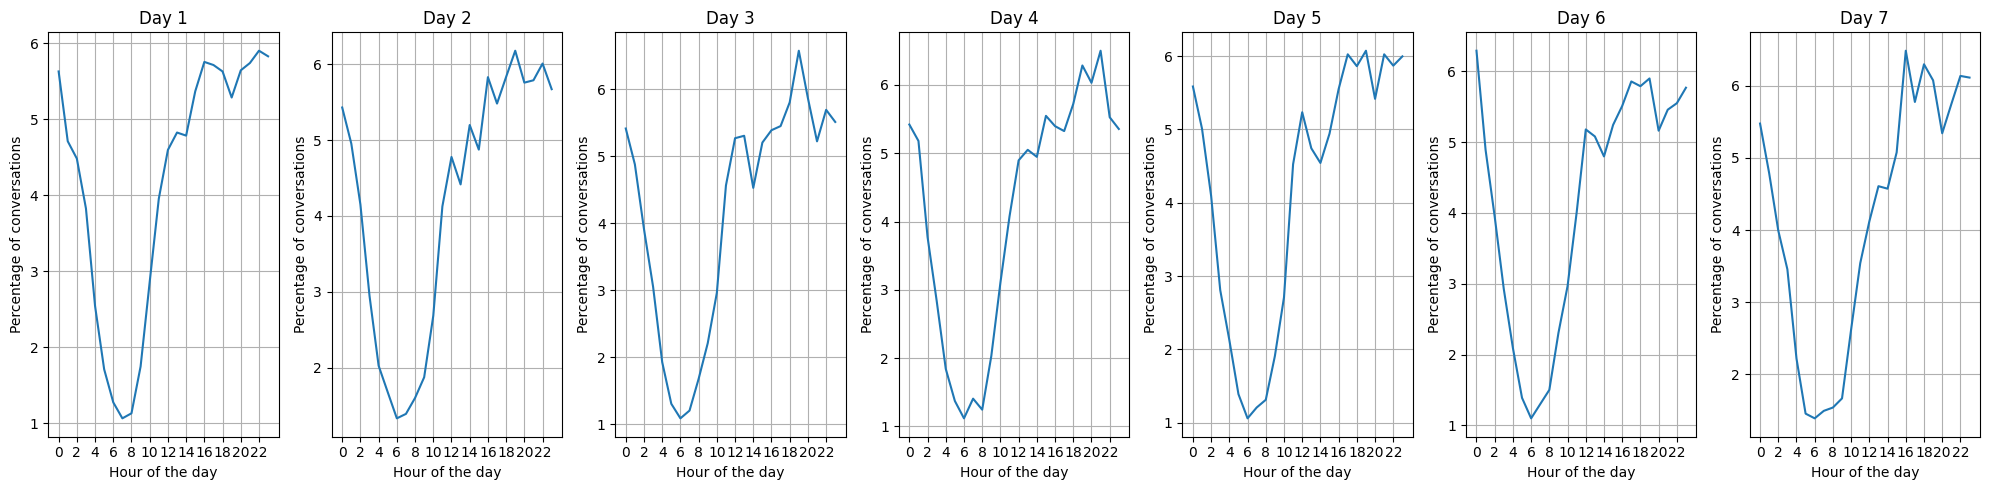

In [14]:
# Extract day of week and hour from offseted_timestamp
repeat_users_df = repeat_users_df.withColumn("day_of_week", F.dayofweek("offseted_timestamp")) 

# Extract hour of the day
repeat_users_df = repeat_users_df.withColumn("hour_bin_offseted", F.hour("offseted_timestamp"))

# Group by day and hour, count conversations
day_hour_counts = repeat_users_df.groupBy("day_of_week", "hour_bin_offseted")\
	.count() \
	.orderBy("day_of_week", "hour_bin_offseted")

# Calculate percentage by days (so 7 total are needed)
total_conversations_per_day = repeat_users_df.groupBy("day_of_week").agg(F.count("*").alias("total_conversations_per_day"))
day_hour_counts = day_hour_counts.join(total_conversations_per_day, "day_of_week")
day_hour_counts = day_hour_counts.withColumn("percentage", (F.col("count") / F.col("total_conversations_per_day")).cast("double") * 100)
day_hour_counts = day_hour_counts.orderBy("day_of_week", "hour_bin_offseted")

day_hour_counts.show(5)
# Convert to pandas for plotting
day_hour_pd = day_hour_counts.toPandas()

# Plot 7 subplots for each day of the week
fig, axes = plt.subplots(1, 7, figsize=(20, 5))

for i in range(1, 8):
	day_data = day_hour_pd[day_hour_pd["day_of_week"] == i]
	axes[i-1].plot(day_data["hour_bin_offseted"], day_data["percentage"])
	axes[i-1].set_title(f"Day {i}")
	axes[i-1].set_xlabel("Hour of the day")
	axes[i-1].set_ylabel("Percentage of conversations")
	axes[i-1].set_xticks(range(0, 24, 2))
	# add grid
	axes[i-1].grid()

plt.tight_layout()
plt.show()

In [ ]:
# Find the earliest month and latest month of the dataset
earliest_month = repeat_users_df.agg(F.min("offseted_timestamp")).collect()[0][0].month
lastest_month = repeat_users_df.agg(F.max("offseted_timestamp")).collect()[0][0].month

earliest_year = repeat_users_df.agg(F.min("offseted_timestamp")).collect()[0][0].year
lastest_year = repeat_users_df.agg(F.max("offseted_timestamp")).collect()[0][0].year

print(f'Earliest month-year: {earliest_month}-{earliest_year}')
print(f'Lastest month-year: {lastest_month}-{lastest_year}')

Earliest month-year: 4-2023
Lastest month-year: 4-2024


+----+-----+-----+--------------------+
|year|month|count|month_year_timestamp|
+----+-----+-----+--------------------+
|2023|    4|16580| 2023-04-01 00:00:00|
|2023|    5|30578| 2023-05-01 00:00:00|
|2023|    6|27619| 2023-06-01 00:00:00|
|2023|    7|17881| 2023-07-01 00:00:00|
|2023|    8|12660| 2023-08-01 00:00:00|
|2023|    9| 7645| 2023-09-01 00:00:00|
|2023|   10| 7996| 2023-10-01 00:00:00|
|2023|   11|13160| 2023-11-01 00:00:00|
|2023|   12|13987| 2023-12-01 00:00:00|
|2024|    1| 7316| 2024-01-01 00:00:00|
|2024|    2|10108| 2024-02-01 00:00:00|
|2024|    3|15562| 2024-03-01 00:00:00|
+----+-----+-----+--------------------+
only showing top 12 rows



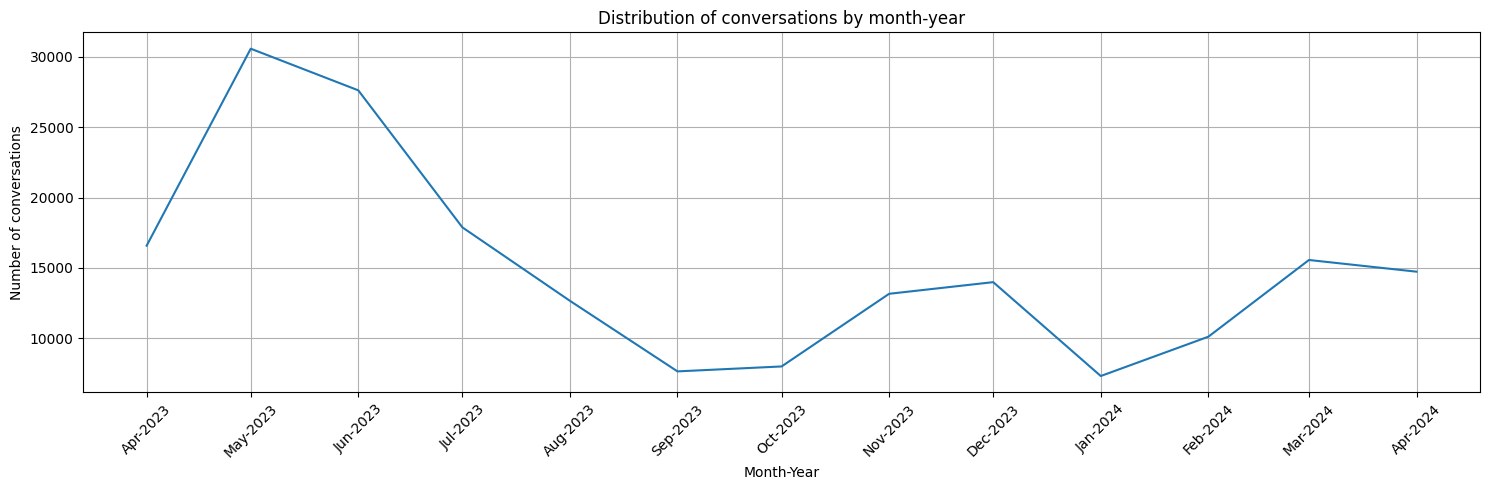

In [20]:
# Count number of conversations group by month and year
date_counts = repeat_users_df.groupBy(F.year("offseted_timestamp").alias("year"), F.month("offseted_timestamp").alias("month")).count().orderBy("year", "month")

# # Create a column for month-year
# date_counts = date_counts.withColumn("month_year", F.concat_ws("-", F.col("month"), F.col("year")))

# Create a column of month-year but actually the timestamp of the first date of the month of that year
date_counts = date_counts.withColumn("month_year_timestamp", F.to_timestamp(F.concat_ws("-", F.col("year"), F.col("month"), F.lit("01"))))

# Sort by month-year
date_counts = date_counts.orderBy("month_year_timestamp")
date_counts.show(12)

# Convert to pandas for plotting
date_counts_pd = date_counts.toPandas()

# Plot the distribution of conversations by month-year
plt.figure(figsize=(15, 5))
plt.plot(date_counts_pd["month_year_timestamp"], date_counts_pd["count"])
plt.xlabel("Month-Year")
plt.ylabel("Number of conversations")
plt.title("Distribution of conversations by month-year")
# Set xticks label for each month-year
plt.xticks(date_counts_pd["month_year_timestamp"], date_counts_pd["month_year_timestamp"].dt.strftime('%b-%Y'), rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()



In [ ]:
# Find the first time (earliest day) and the last time (latest day) of the dataset
earliest_day = repeat_users_df.agg(F.min("offseted_timestamp")).collect()[0][0]
latest_day = repeat_users_df.agg(F.max("offseted_timestamp")).collect()[0][0]

print(f"Earliest day: {earliest_day}")
print(f"Latest day: {latest_day}")

Earliest day: 2023-04-08 20:02:58
Latest day: 2024-04-30 12:51:22


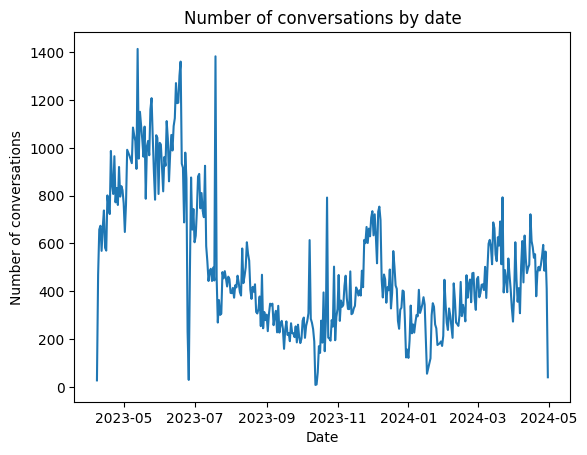

+----------+-----+
|      date|count|
+----------+-----+
|2023-05-13| 1414|
|2023-07-19| 1383|
|2023-06-19| 1361|
|2023-06-18| 1302|
|2023-06-15| 1271|
+----------+-----+
only showing top 5 rows



In [ ]:
# Count number of conversations group by date
date_counts = repeat_users_df.groupBy(F.to_date("offseted_timestamp").alias("date")).count().orderBy("date")

# Plot the line plot of number of conversations by date
date_counts_pd = date_counts.toPandas()
plt.plot(date_counts_pd["date"], date_counts_pd["count"])
plt.xlabel("Date")
plt.ylabel("Number of conversations")
plt.title("Number of conversations by date")
plt.show()

# find peak dates
date_counts.orderBy(F.desc("count")).show(5)

+----+-----+------------------+--------------------+
|year|month|         avg_turns|month_year_timestamp|
+----+-----+------------------+--------------------+
|2023|    4|3.3218938480096503| 2023-04-01 00:00:00|
|2023|    5| 2.912191771862123| 2023-05-01 00:00:00|
|2023|    6|3.0078931170570984| 2023-06-01 00:00:00|
|2023|    7| 2.830658240590571| 2023-07-01 00:00:00|
|2023|    8|2.3864928909952607| 2023-08-01 00:00:00|
|2023|    9|2.1192936559843036| 2023-09-01 00:00:00|
|2023|   10|2.0894197098549276| 2023-10-01 00:00:00|
|2023|   11|2.5401215805471127| 2023-11-01 00:00:00|
|2023|   12|2.8163294487738613| 2023-12-01 00:00:00|
|2024|    1|2.9931656642974303| 2024-01-01 00:00:00|
|2024|    2|2.8950336367233875| 2024-02-01 00:00:00|
|2024|    3|3.0906053206528723| 2024-03-01 00:00:00|
+----+-----+------------------+--------------------+
only showing top 12 rows



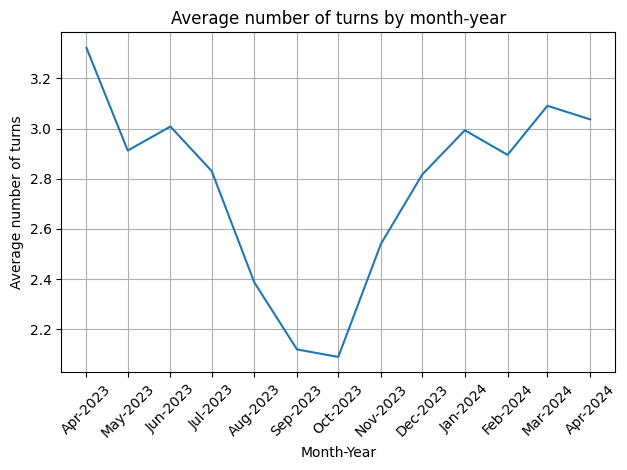

In [21]:
# Calculate avg number of turns group by month and year
turns_month_year = repeat_users_df.groupBy(F.year("offseted_timestamp").alias("year"), F.month("offseted_timestamp").alias("month")).agg(F.avg("turn").alias("avg_turns")).orderBy("year", "month")

# Create a column of month-year but actually the timestamp of the first date of the month of that year
turns_month_year = turns_month_year.withColumn("month_year_timestamp", F.to_timestamp(F.concat_ws("-", F.col("year"), F.col("month"), F.lit("01"))))

# Sort by month-year
turns_month_year = turns_month_year.orderBy("month_year_timestamp")
turns_month_year.show(12)

# Convert to pandas for plotting
turns_month_year_pd = turns_month_year.toPandas()

# Plot the line plot of avg number of turns by month-year
plt.plot(turns_month_year_pd["month_year_timestamp"], turns_month_year_pd["avg_turns"])
plt.xlabel("Month-Year")
plt.ylabel("Average number of turns")
plt.title("Average number of turns by month-year")
# Set xticks label for each month-year
plt.xticks(turns_month_year_pd["month_year_timestamp"], turns_month_year_pd["month_year_timestamp"].dt.strftime('%b-%Y'), rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

+------------+----+-----+------------------+--------------------+
|model_family|year|month|         avg_turns|month_year_timestamp|
+------------+----+-----+------------------+--------------------+
|       GPT-4|2023|    4| 2.005110081665791| 2023-04-01 00:00:00|
|     GPT-3.5|2023|    4|3.7796067672610882| 2023-04-01 00:00:00|
|       GPT-4|2023|    5|1.8009603469640645| 2023-05-01 00:00:00|
|     GPT-3.5|2023|    5|3.1552656238737113| 2023-05-01 00:00:00|
|     GPT-3.5|2023|    6|2.7993792910565585| 2023-06-01 00:00:00|
|       GPT-4|2023|    6|1.8760500499324444| 2023-06-01 00:00:00|
|     GPT-3.5|2023|    7| 2.336240320601236| 2023-07-01 00:00:00|
|     GPT-3.5|2023|    8| 2.132765568035896| 2023-08-01 00:00:00|
|     GPT-3.5|2023|    9| 2.035356690285388| 2023-09-01 00:00:00|
|     GPT-3.5|2023|   10| 1.924245886654479| 2023-10-01 00:00:00|
|     GPT-3.5|2023|   11| 2.243937158006086| 2023-11-01 00:00:00|
|       GPT-4|2023|   11| 3.512192851824274| 2023-11-01 00:00:00|
+---------

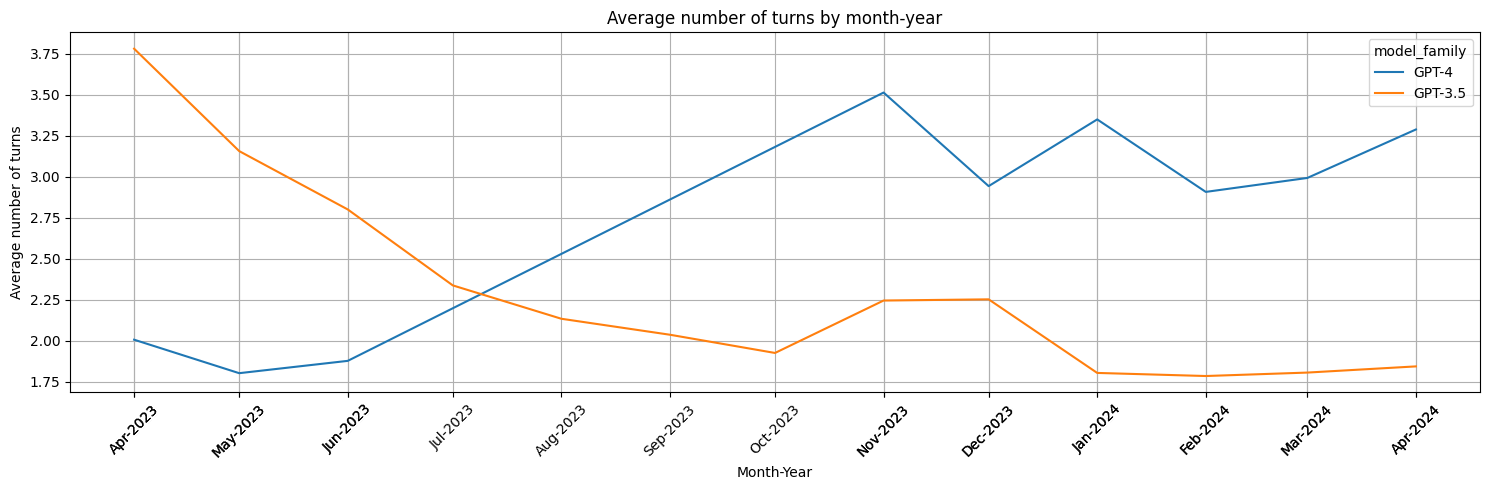

In [29]:
# # Create a new column 'model_family' based on the model name
# wildchat_df = wildchat_df.withColumn(
# 	"model_family",
# 	F.when(F.col("model").like("gpt-3.5%"), "GPT-3.5")
# 	 .when(F.col("model").like("gpt-4%"), "GPT-4")
# 	 .otherwise("Other")
# )

# Group by model family and month and year and calculate avg turn
model_month_year = wildchat_df.groupBy("model_family", F.year("offseted_timestamp").alias("year"), F.month("offseted_timestamp").alias("month")).agg(F.avg("turn").alias("avg_turns")).orderBy("year", "month")

# Create a column of month-year but actually the timestamp of the first date of the month of that year
model_month_year = model_month_year.withColumn("month_year_timestamp", F.to_timestamp(F.concat_ws("-", F.col("year"), F.col("month"), F.lit("01"))))
model_month_year.show(12)

# Convert to pandas for plotting
model_month_year_pd = model_month_year.toPandas()

# Plot the line plot of avg turns by month-year
plt.figure(figsize=(15, 5))
sns.lineplot(data=model_month_year_pd, x="month_year_timestamp", y="avg_turns", hue="model_family")
plt.xlabel("Month-Year")
plt.ylabel("Average number of turns")
plt.title("Average number of turns by month-year")
# Set xticks label for each month-year
plt.xticks(model_month_year_pd["month_year_timestamp"], model_month_year_pd["month_year_timestamp"].dt.strftime('%b-%Y'), rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

**Diverging Trends:**

- GPT-3.5 shows a steady decline from ~3.75 turns to ~1.75 turns
- GPT-4 shows an overall increase from ~2.0 to ~3.25 turns

**Crossover Point:**

- The lines intersect around July-August 2023
- After this point, GPT-4 consistently maintains higher average turns

**GPT-4 Pattern:**

- Shows more volatility with several peaks and troughs
- Notable peaks in November 2023 (~3.5 turns) and January 2024 (~3.35 turns)
- **Overall upward trend despite fluctuations**

**GPT-3.5 Pattern:**

- Steady decline until September 2023
- Slight uptick around November-December 2023
- Stabilizes around 1.75-2.0 turns from January 2024 onwards

=> This suggests users tend to have longer conversations with GPT-4 compared to GPT-3.5, possibly indicating higher engagement or satisfaction with GPT-4's responses.

**Reasons:**
- GPT-4's Upward Trend: due to performance improvements over time such as:
	- Improved response quality
	- Better context handling -> encourage longer conversations
	- Faster response times

- GPT-3.5's Decline: 
	- User Behavior Shift: 
		- Migrating complex/lengthy queries to GPT-4
		- Use GPT-3.5 for basic queries, GPT-4 for deeper discussions

	- GPT-3.5's stabilization around 1.75 turns suggests it found its niche for brief interactions

- The July-August 2023 crossover coincides with wider GPT-4 availability. In fact, on July 6, 2023 , we gave access to the GPT-4 API (8k) to all API users who have made a successful payment. (https://www.siliconrepublic.com/machines/openai-gpt-4-api-availability-for-developers-superintelligent-ai-team)





# Question 9:

In [7]:
!pip install keybert


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: pip install --upgrade pip


In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, concat_ws, collect_list
from pyspark.ml.feature import Tokenizer, StopWordsRemover, CountVectorizer, RegexTokenizer
from pyspark.ml.clustering import LDA
from pyspark.ml import Pipeline
import numpy as np

class TopicExtractor:
	def __init__(self, num_topics=10, max_iterations=20, vocab_size=10000):
		self.num_topics = num_topics
		self.max_iterations = max_iterations
		self.vocab_size = vocab_size
		
	def preprocess_text(self, df, text_col):
		"""Preprocess text data"""
		
		# Create preprocessing pipeline
		# tokenizer = Tokenizer(
		# 	inputCol=text_col, 
		# 	outputCol="words"
		# )
		# Create a RegexTokenizer instance
		tokenizer = RegexTokenizer(inputCol=text_col, outputCol="words", pattern="\\W+|\\d+")
		
		remover = StopWordsRemover(
			inputCol="words", 
			outputCol="filtered_words"
		)

		# remove punctuation
		df = df.withColumn("text", F.regexp_replace(F.col(text_col), "[^a-zA-Z0-9\\s]", ""))
		
		vectorizer = CountVectorizer(
			inputCol="filtered_words", 
			outputCol="features",
			vocabSize=self.vocab_size,
			minDF=2.0  # Minimum document frequency
		)
		
		pipeline = Pipeline(stages=[
			tokenizer,
			remover,
			vectorizer
		])
		
		# Fit and transform
		model = pipeline.fit(df)
		processed_df = model.transform(df)
		
		return processed_df, model.stages[-1].vocabulary
	
	def train_lda(self, processed_df):
		"""Train LDA model"""
		lda = LDA(
			k=self.num_topics,
			maxIter=self.max_iterations,
			featuresCol="features",
			optimizeDocConcentration=True,
			seed=42
		)
		
		lda_model = lda.fit(processed_df)
		return lda_model
	
	def extract_topics(self, lda_model, vocabulary, top_n=10):
		"""Extract top words for each topic"""
		topics = []
		topic_matrix = lda_model.topicsMatrix().toArray()

		for topic_idx in tqdm(range(self.num_topics)):
			# Get word weights for topic
			word_weights = topic_matrix[:, topic_idx]
			# Get top words
			top_indices = word_weights.argsort()[-top_n:][::-1]
			top_words = [(vocabulary[i], float(word_weights[i])) 
						for i in top_indices]
			topics.append(top_words)
			
		return topics
	
	def get_document_topics(self, lda_model, processed_df):
		"""Get topic distribution for each document"""
		return lda_model.transform(processed_df)
	
	def evaluate_model(self, lda_model, processed_df):
		"""Calculate model metrics"""
		log_perplexity = lda_model.logPerplexity(processed_df)
		log_likelihood = lda_model.logLikelihood(processed_df)
		
		return {
			'log_perplexity': log_perplexity,
			'log_likelihood': log_likelihood
		}

def run_topic_extraction(df, text_col, num_topics=10):
	"""Main function to run topic extraction"""
	# Initialize
	extractor = TopicExtractor(num_topics=num_topics)
	
	# Preprocess
	processed_df, vocabulary = extractor.preprocess_text(df, text_col)
	
	processed_df.show()
	
	# Train LDA
	lda_model = extractor.train_lda(processed_df)
	
	# Extract topics
	topics = extractor.extract_topics(lda_model, vocabulary)
	
	# Get document topics
	doc_topics = extractor.get_document_topics(lda_model, processed_df)
	
	# Evaluate
	metrics = extractor.evaluate_model(lda_model, processed_df)
	
	return topics, doc_topics, metrics

# Example usage:
"""

# Run topic extraction
topics, doc_topics, metrics = run_topic_extraction(
	df, 
	text_col="text", 
	num_topics=3
)

# Print results
for i, topic in enumerate(topics):
	print(f"\nTopic {i}:")
	for word, weight in topic:
		print(f"{word}: {weight:.4f}")

print("\nMetrics:")
print(f"Log Perplexity: {metrics['log_perplexity']}")
print(f"Log Likelihood: {metrics['log_likelihood']}")
"""

'\n\n# Run topic extraction\ntopics, doc_topics, metrics = run_topic_extraction(\n\tdf, \n\ttext_col="text", \n\tnum_topics=3\n)\n\n# Print results\nfor i, topic in enumerate(topics):\n\tprint(f"\nTopic {i}:")\n\tfor word, weight in topic:\n\t\tprint(f"{word}: {weight:.4f}")\n\nprint("\nMetrics:")\nprint(f"Log Perplexity: {metrics[\'log_perplexity\']}")\nprint(f"Log Likelihood: {metrics[\'log_likelihood\']}")\n'

In [20]:
# Apply to DataFrame
# Filter out only English messages
wildchat_df_en = wildchat_df.filter(F.col("language") == "English")
wildchat_df_en = wildchat_df_en.withColumn("full_text", F.concat_ws(" ", F.col("conversation.content")))
wildchat_df_en.show(5)

topics, doc_topics, metrics = run_topic_extraction(
    wildchat_df_en, 
    text_col="full_text", 
    num_topics=30
)

# Print results
for i, topic in enumerate(topics):
    print(f"\nTopic {i}:")
    for word, weight in topic:
        print(f"{word}: {weight:.4f}")

print("\nMetrics:")
print(f"Log Perplexity: {metrics['log_perplexity']}")
print(f"Log Likelihood: {metrics['log_likelihood']}")

+--------------------+------------------+-------------------+---------------------+----+--------+--------------------+--------------------+-----+--------+-------------+-------------+--------------------+--------------------+-----------------------+
|   conversation_hash|             model|          timestamp|         conversation|turn|language|   openai_moderation| detoxify_moderation|toxic|redacted|        state|      country|           hashed_ip|              header|              full_text|
+--------------------+------------------+-------------------+---------------------+----+--------+--------------------+--------------------+-----+--------+-------------+-------------+--------------------+--------------------+-----------------------+
|f01a345e668b978b6...|gpt-3.5-turbo-0613|2023-09-13 04:14:27| [{(In the clubroo...|   1| English|[{{false, false, ...|[{2.1957975695841...|false|   false|     Michigan|United States|f96c8515aa663db23...|{en-US,en;q=0.9, ...|   (In the clubroom…...|
|867

25/01/09 15:38:08 WARN StopWordsRemover: Default locale set was [en_VN]; however, it was not found in available locales in JVM, falling back to en_US locale. Set param `locale` in order to respect another locale.


+--------------------+------------------+-------------------+---------------------+----+--------+--------------------+--------------------+-----+--------+---------------+-------------+--------------------+--------------------+-----------------------+--------------------+--------------------+--------------------+--------------------+
|   conversation_hash|             model|          timestamp|         conversation|turn|language|   openai_moderation| detoxify_moderation|toxic|redacted|          state|      country|           hashed_ip|              header|              full_text|                text|               words|      filtered_words|            features|
+--------------------+------------------+-------------------+---------------------+----+--------+--------------------+--------------------+-----+--------+---------------+-------------+--------------------+--------------------+-----------------------+--------------------+--------------------+--------------------+-----------------

25/01/09 15:40:10 WARN MemoryStore: Not enough space to cache rdd_687_7 in memory! (computed 42.5 MiB so far)
25/01/09 15:40:10 WARN BlockManager: Persisting block rdd_687_7 to disk instead.
25/01/09 15:40:19 WARN MemoryStore: Not enough space to cache rdd_687_7 in memory! (computed 42.5 MiB so far)
25/01/09 15:40:22 WARN MemoryStore: Not enough space to cache rdd_687_15 in memory! (computed 2.5 MiB so far)
25/01/09 15:40:22 WARN BlockManager: Persisting block rdd_687_15 to disk instead.
25/01/09 15:40:24 WARN MemoryStore: Not enough space to cache rdd_687_13 in memory! (computed 9.2 MiB so far)
25/01/09 15:40:24 WARN BlockManager: Persisting block rdd_687_13 to disk instead.
25/01/09 15:40:25 WARN MemoryStore: Not enough space to cache rdd_687_10 in memory! (computed 19.6 MiB so far)
25/01/09 15:40:25 WARN BlockManager: Persisting block rdd_687_10 to disk instead.
25/01/09 15:40:26 WARN MemoryStore: Not enough space to cache rdd_687_9 in memory! (computed 29.4 MiB so far)
25/01/09 15:

ConnectionRefusedError: [Errno 61] Connection refused

In [19]:
doc_topics.show()

@udf(returnType=IntegerType())
def get_dominant_topic(topic_distribution):
    return int(np.argmax(topic_distribution.toArray()))  # Convert to array for argmax

doc_topics_with_dominant_topic = doc_topics.withColumn(
    "dominant_topic", 
    get_dominant_topic(col("topicDistribution"))
)

# Display the DataFrame with the dominant topic for each document
doc_topics_with_dominant_topic.show()


25/01/09 15:37:37 WARN DAGScheduler: Broadcasting large task binary with size 1864.7 KiB


+--------------------+------------------+-------------------+---------------------+----+--------+--------------------+--------------------+-----+--------+---------------+-------------+--------------------+--------------------+-----------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|   conversation_hash|             model|          timestamp|         conversation|turn|language|   openai_moderation| detoxify_moderation|toxic|redacted|          state|      country|           hashed_ip|              header|              full_text|                text|               words|      filtered_words|            features|   topicDistribution|
+--------------------+------------------+-------------------+---------------------+----+--------+--------------------+--------------------+-----+--------+---------------+-------------+--------------------+--------------------+-----------------------+--------------------+-----------------

25/01/09 15:37:37 WARN DAGScheduler: Broadcasting large task binary with size 1939.1 KiB


+--------------------+------------------+-------------------+---------------------+----+--------+--------------------+--------------------+-----+--------+---------------+-------------+--------------------+--------------------+-----------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------+
|   conversation_hash|             model|          timestamp|         conversation|turn|language|   openai_moderation| detoxify_moderation|toxic|redacted|          state|      country|           hashed_ip|              header|              full_text|                text|               words|      filtered_words|            features|   topicDistribution|dominant_topic|
+--------------------+------------------+-------------------+---------------------+----+--------+--------------------+--------------------+-----+--------+---------------+-------------+--------------------+--------------------+-----------------------+--------

In [9]:
# # collect the list of messages
# wildchat_df.select(col('conversation.role')).first().role

# Get the first 5 rows
tmp = wildchat_df.limit(5)
tmpp = tmp.select(col('conversation')).toPandas()
tmp = tmp.withColumn("full_text", F.concat_ws(" ", F.col("conversation.content"), F.col("conversation.role"))).select(col("full_text"))
tmpp2 = tmp.select(col('full_text')).toPandas()


In [ ]:
# Apply to DataFrame
# Filter out only English messages
wildchat_df_en = wildchat_df.filter(F.col("language") == "en").limit(5)
# Explode messages in conversation into a single conversation text
# this is how the conversation look like
# message schema: dict_keys(['content', 'country', 'hashed_ip', 'header', 'language', 'redacted', 'role', 'state', 'timestamp', 'toxic', 'turn_identifier'])
# each conversation is identified by conversation_hash
# conversation column is a list of messages in the conversation
wildchat_df_en = wildchat_df_en.withColumn("full_text", F.concat_ws(" ", F.col("conversation.content")))

df_with_topics = wildchat_df_en.withColumn("topics", extract_topics_udf()("full_text"))
df_with_topics.select("topics").show(5, truncate=False)

/Users/lgk1910/anaconda3/envs/sl/lib/python3.10/site-packages/transformers/utils/generic.py:482: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
/Users/lgk1910/anaconda3/envs/sl/lib/python3.10/site-packages/transformers/utils/generic.py:339: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
/Users/lgk1910/anaconda3/envs/sl/lib/python3.10/site-packages/transformers/utils/generic.py:339: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
/Users/lgk1910/anaconda3/envs/sl/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Users/lgk1910/anaconda3/envs/sl/lib/python3.10/s

Py4JJavaError: An error occurred while calling o152.showString.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 0 in stage 15.0 failed 1 times, most recent failure: Lost task 0.0 in stage 15.0 (TID 60) (localhost executor driver): org.apache.spark.SparkException: Python worker exited unexpectedly (crashed)
	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator$$anonfun$1.applyOrElse(PythonRunner.scala:612)
	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator$$anonfun$1.applyOrElse(PythonRunner.scala:594)
	at scala.runtime.AbstractPartialFunction.apply(AbstractPartialFunction.scala:38)
	at org.apache.spark.sql.execution.python.BasePythonUDFRunner$$anon$1.read(PythonUDFRunner.scala:99)
	at org.apache.spark.sql.execution.python.BasePythonUDFRunner$$anon$1.read(PythonUDFRunner.scala:75)
	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.hasNext(PythonRunner.scala:525)
	at org.apache.spark.InterruptibleIterator.hasNext(InterruptibleIterator.scala:37)
	at scala.collection.Iterator$$anon$11.hasNext(Iterator.scala:491)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage2.processNext(Unknown Source)
	at org.apache.spark.sql.execution.BufferedRowIterator.hasNext(BufferedRowIterator.java:43)
	at org.apache.spark.sql.execution.WholeStageCodegenEvaluatorFactory$WholeStageCodegenPartitionEvaluator$$anon$1.hasNext(WholeStageCodegenEvaluatorFactory.scala:43)
	at org.apache.spark.sql.execution.SparkPlan.$anonfun$getByteArrayRdd$1(SparkPlan.scala:388)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitionsInternal$2(RDD.scala:893)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitionsInternal$2$adapted(RDD.scala:893)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:367)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:331)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:93)
	at org.apache.spark.TaskContext.runTaskWithListeners(TaskContext.scala:166)
	at org.apache.spark.scheduler.Task.run(Task.scala:141)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$4(Executor.scala:620)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally(SparkErrorUtils.scala:64)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally$(SparkErrorUtils.scala:61)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:94)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:623)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1128)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:628)
	at java.base/java.lang.Thread.run(Thread.java:829)
Caused by: java.io.EOFException
	at java.base/java.io.DataInputStream.readInt(DataInputStream.java:397)
	at org.apache.spark.sql.execution.python.BasePythonUDFRunner$$anon$1.read(PythonUDFRunner.scala:83)
	... 26 more

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.failJobAndIndependentStages(DAGScheduler.scala:2856)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2(DAGScheduler.scala:2792)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2$adapted(DAGScheduler.scala:2791)
	at scala.collection.mutable.ResizableArray.foreach(ResizableArray.scala:62)
	at scala.collection.mutable.ResizableArray.foreach$(ResizableArray.scala:55)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:2791)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1(DAGScheduler.scala:1247)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1$adapted(DAGScheduler.scala:1247)
	at scala.Option.foreach(Option.scala:407)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:1247)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:3060)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2994)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2983)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:989)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2393)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2414)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2433)
	at org.apache.spark.sql.execution.SparkPlan.executeTake(SparkPlan.scala:530)
	at org.apache.spark.sql.execution.SparkPlan.executeTake(SparkPlan.scala:483)
	at org.apache.spark.sql.execution.CollectLimitExec.executeCollect(limit.scala:61)
	at org.apache.spark.sql.Dataset.collectFromPlan(Dataset.scala:4333)
	at org.apache.spark.sql.Dataset.$anonfun$head$1(Dataset.scala:3316)
	at org.apache.spark.sql.Dataset.$anonfun$withAction$2(Dataset.scala:4323)
	at org.apache.spark.sql.execution.QueryExecution$.withInternalError(QueryExecution.scala:546)
	at org.apache.spark.sql.Dataset.$anonfun$withAction$1(Dataset.scala:4321)
	at org.apache.spark.sql.execution.SQLExecution$.$anonfun$withNewExecutionId$6(SQLExecution.scala:125)
	at org.apache.spark.sql.execution.SQLExecution$.withSQLConfPropagated(SQLExecution.scala:201)
	at org.apache.spark.sql.execution.SQLExecution$.$anonfun$withNewExecutionId$1(SQLExecution.scala:108)
	at org.apache.spark.sql.SparkSession.withActive(SparkSession.scala:900)
	at org.apache.spark.sql.execution.SQLExecution$.withNewExecutionId(SQLExecution.scala:66)
	at org.apache.spark.sql.Dataset.withAction(Dataset.scala:4321)
	at org.apache.spark.sql.Dataset.head(Dataset.scala:3316)
	at org.apache.spark.sql.Dataset.take(Dataset.scala:3539)
	at org.apache.spark.sql.Dataset.getRows(Dataset.scala:280)
	at org.apache.spark.sql.Dataset.showString(Dataset.scala:315)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at java.base/jdk.internal.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.base/java.lang.reflect.Method.invoke(Method.java:566)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:374)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.ClientServerConnection.waitForCommands(ClientServerConnection.java:182)
	at py4j.ClientServerConnection.run(ClientServerConnection.java:106)
	at java.base/java.lang.Thread.run(Thread.java:829)
Caused by: org.apache.spark.SparkException: Python worker exited unexpectedly (crashed)
	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator$$anonfun$1.applyOrElse(PythonRunner.scala:612)
	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator$$anonfun$1.applyOrElse(PythonRunner.scala:594)
	at scala.runtime.AbstractPartialFunction.apply(AbstractPartialFunction.scala:38)
	at org.apache.spark.sql.execution.python.BasePythonUDFRunner$$anon$1.read(PythonUDFRunner.scala:99)
	at org.apache.spark.sql.execution.python.BasePythonUDFRunner$$anon$1.read(PythonUDFRunner.scala:75)
	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.hasNext(PythonRunner.scala:525)
	at org.apache.spark.InterruptibleIterator.hasNext(InterruptibleIterator.scala:37)
	at scala.collection.Iterator$$anon$11.hasNext(Iterator.scala:491)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage2.processNext(Unknown Source)
	at org.apache.spark.sql.execution.BufferedRowIterator.hasNext(BufferedRowIterator.java:43)
	at org.apache.spark.sql.execution.WholeStageCodegenEvaluatorFactory$WholeStageCodegenPartitionEvaluator$$anon$1.hasNext(WholeStageCodegenEvaluatorFactory.scala:43)
	at org.apache.spark.sql.execution.SparkPlan.$anonfun$getByteArrayRdd$1(SparkPlan.scala:388)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitionsInternal$2(RDD.scala:893)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitionsInternal$2$adapted(RDD.scala:893)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:367)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:331)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:93)
	at org.apache.spark.TaskContext.runTaskWithListeners(TaskContext.scala:166)
	at org.apache.spark.scheduler.Task.run(Task.scala:141)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$4(Executor.scala:620)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally(SparkErrorUtils.scala:64)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally$(SparkErrorUtils.scala:61)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:94)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:623)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1128)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:628)
	... 1 more
Caused by: java.io.EOFException
	at java.base/java.io.DataInputStream.readInt(DataInputStream.java:397)
	at org.apache.spark.sql.execution.python.BasePythonUDFRunner$$anon$1.read(PythonUDFRunner.scala:83)
	... 26 more


# Question 10: Determine whether there's relation between harmful conversation and the length of the conversation as well as the first time it happens

- Combine both dataset
=

In [7]:
# Select only the openai_moderation column and the turn columns
harmful_df = wildchat_df.select("conversation_hash", "conversation", "openai_moderation", "turn")

# create column to check if the message is harmful, i.e., any message is flagged as True
# the content of openai_moderation look like this:
# [
    # {
    #     "categories": {
    #         "harassment": false,
    #         "harassment/threatening": false,
    #         "harassment_threatening": false,
    #         "hate": false,
    #         "hate/threatening": false,
    #         "hate_threatening": false,
    #         "self-harm": false,
    #         "self-harm/instructions": false,
    #         "self-harm/intent": false,
    #         "self_harm": false,
    #         "self_harm_instructions": false,
    #         "self_harm_intent": false,
    #         "sexual": false,
    #         "sexual/minors": false,
    #         "sexual_minors": false,
    #         "violence": false,
    #         "violence/graphic": false,
    #         "violence_graphic": false
    #     },
    #     "category_scores": {
    #         "harassment": 0.004603718873113394,
    #         "harassment/threatening": 0.0019740513525903225,
    #         "harassment_threatening": 0.0019740513525903225,
    #         "hate": 0.00020820603822357953,
    #         "hate/threatening": 0.000009125921678787563,
    #         "hate_threatening": 0.000009125921678787563,
    #         "self-harm": 0.000007066340458550258,
    #         "self-harm/instructions": 1.4673626935746142e-7,
    #         "self-harm/intent": 0.000002532277903810609,
    #         "self_harm": 0.000007066340458550258,
    #         "self_harm_instructions": 1.4673626935746142e-7,
    #         "self_harm_intent": 0.000002532277903810609,
    #         "sexual": 0.01830160990357399,
    #         "sexual/minors": 0.000003873964033118682,
    #         "sexual_minors": 0.000003873964033118682,
    #         "violence": 0.23802417516708374,
    #         "violence/graphic": 0.0411539226770401,
    #         "violence_graphic": 0.0411539226770401
    #     },
    #     "flagged": false
    # },

# ] 

# we determine a conversation is harmful if any message in the conversation is flagged as harmful
# create a column to check if the conversation is harmful
harmful_df = harmful_df.withColumn("is_harmful", F.array_contains(F.col("openai_moderation.flagged"), True))

# Count the number of harmful conversations
num_harmful = harmful_df.filter(F.col("is_harmful")).count()

# Create a column of the first message index a harmful conversation appears
# Create a column to check if the conversation is harmful
harmful_df = harmful_df.withColumn(
	"harmful_message_index",
	F.when(F.col("is_harmful"), F.array_position(F.col("openai_moderation.flagged"), True) - 1)
)


In [8]:
# # get the conversation of harmful messages where conversation_hash is 7a7678058af96b7019edcb533d736b2b
# tmp2 = harmful_df.filter(F.col("conversation_hash") == "7a7678058af96b7019edcb533d736b2b").toPandas()
# tmp2

In [9]:
# Calculate the average turn and std of harmful vs non-harmful conversations
avg_turns_harmful = harmful_df.filter(F.col("is_harmful")).agg(F.avg("turn")).collect()[0][0]
std_turns_harmful = harmful_df.filter(F.col("is_harmful")).agg(F.stddev("turn")).collect()[0][0]
median_turns_harmful = harmful_df.filter(F.col("is_harmful")).agg(F.expr("percentile_approx(turn, 0.5)")).collect()[0][0]
avg_turns_non_harmful = harmful_df.filter(~F.col("is_harmful")).agg(F.avg("turn")).collect()[0][0]
std_turns_non_harmful = harmful_df.filter(~F.col("is_harmful")).agg(F.stddev("turn")).collect()[0][0]
median_turns_non_harmful = harmful_df.filter(~F.col("is_harmful")).agg(F.expr("percentile_approx(turn, 0.5)")).collect()[0][0]

print(f"Average turns for harmful conversations: {avg_turns_harmful:.2f}")
print(f"Std Dev of turns for harmful conversations: {std_turns_harmful:.2f}")
print(f"Median turns for harmful conversations: {median_turns_harmful:.2f}")

print(f"Average turns for non-harmful conversations: {avg_turns_non_harmful:.2f}")
print(f"Std Dev of turns for non-harmful conversations: {std_turns_non_harmful:.2f}")
print(f"Median turns for non-harmful conversations: {median_turns_non_harmful:.2f}")

# Average turns worldwide
avg_turns_worldwide = harmful_df.agg(F.avg("turn")).collect()[0][0]
std_turns_worldwide = harmful_df.agg(F.stddev("turn")).collect()[0][0]
median_turns_worldwide = harmful_df.agg(F.expr("percentile_approx(turn, 0.5)")).collect()[0][0]

print(f"Average turns worldwide: {avg_turns_worldwide:.2f}")
print(f"Std Dev of turns worldwide: {std_turns_worldwide:.2f}")
print(f"Median turns worldwide: {median_turns_worldwide:.2f}")

Average turns for harmful conversations: 3.23
Std Dev of turns for harmful conversations: 5.77
Median turns for harmful conversations: 1.00
Average turns for non-harmful conversations: 2.43
Std Dev of turns for non-harmful conversations: 3.27
Median turns for non-harmful conversations: 1.00
Average turns worldwide: 2.53
Std Dev of turns worldwide: 3.63
Median turns worldwide: 1.00


+---------------------+-----+
|harmful_message_index|count|
+---------------------+-----+
|                    0|53224|
|                    1|14528|
|                    2| 4063|
|                    3| 2489|
|                    4| 1943|
|                    5| 1159|
|                    6| 1112|
|                    7|  642|
|                    8|  790|
|                    9|  363|
|                   10|  521|
|                   11|  207|
|                   12|  393|
|                   13|  152|
|                   14|  246|
|                   15|   84|
|                   16|  232|
|                   17|   56|
|                   18|  191|
|                   19|   52|
+---------------------+-----+
only showing top 20 rows



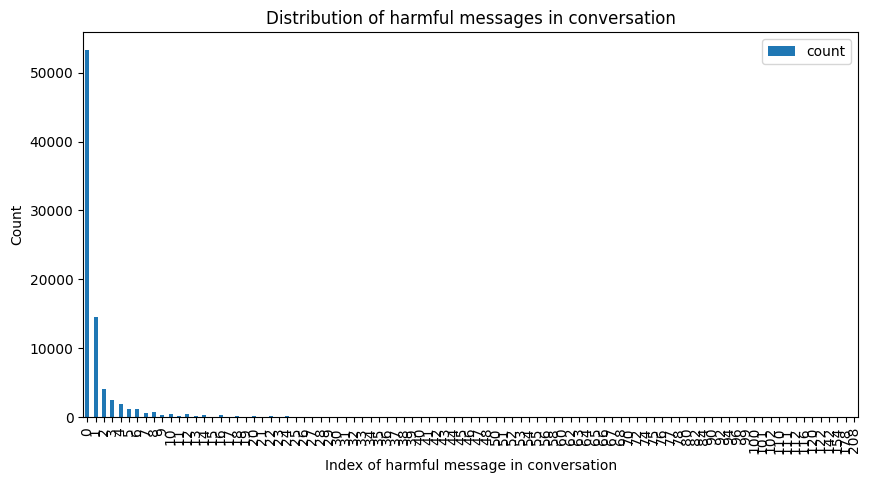

In [10]:
# Check the distribution of the first index of harmful messages
harmful_df.filter(F.col('is_harmful') == 1).groupBy("harmful_message_index").count().orderBy("harmful_message_index").show()

# Plot histogram of harmful message index
harmful_pd = harmful_df.filter(F.col('is_harmful')).groupBy("harmful_message_index").count().orderBy("harmful_message_index").toPandas()

harmful_pd.plot(kind='bar', x='harmful_message_index', y='count', figsize=(10, 5))
plt.xlabel("Index of harmful message in conversation")
plt.ylabel("Count")
plt.title("Distribution of harmful messages in conversation")
plt.show()


### Question 9.1: Determine whether there's relation between harmful conversation and the time of the day

In [8]:
# open the parquet file
country_state_df = spark.read.parquet("../country_state_timezone.parquet")
country_state_df.count() # 2433

2433

In [9]:
# join condition to handle cases when 'state' is null
wildchat_df = wildchat_df.join(
    country_state_df,
    (
        (wildchat_df["country"] == country_state_df["ccountry"]) &
        (
            (wildchat_df["state"] == country_state_df["sstate"]) |
            (wildchat_df["state"].isNull() & country_state_df["sstate"].isNull())
        )
    ),
    "left"
)


# Select the required columns and filter to show rows where 'timezone' is null, supposed to be 1262 (only a small fraction)
print(wildchat_df.select("country", "state", "timezone").filter(F.col("timezone").isNull()).count()) # 1262

# drop ccountry and sstate columns
wildchat_df = wildchat_df.drop("ccountry", "sstate")
wildchat_df.columns

# Shift the timestamp by adding the GMT offset hours
wildchat_df = wildchat_df.withColumn(
	"offseted_timestamp",
	(F.unix_timestamp("timestamp") + F.col("gmt_offset.hours") * 3600 + F.col("gmt_offset.minutes") * 60).cast("timestamp")
)

wildchat_df.select("timestamp", "gmt_offset", "offseted_timestamp").show(5)

1262
+-------------------+----------+-------------------+
|          timestamp|gmt_offset| offseted_timestamp|
+-------------------+----------+-------------------+
|2023-09-13 04:14:27|   {-5, 0}|2023-09-12 23:14:27|
|2023-09-13 04:14:58|    {8, 0}|2023-09-13 12:14:58|
|2023-09-13 04:15:23|    {1, 0}|2023-09-13 05:15:23|
|2023-09-13 04:16:17|    {9, 0}|2023-09-13 13:16:17|
|2023-09-13 04:16:35|   {-5, 0}|2023-09-12 23:16:35|
+-------------------+----------+-------------------+
only showing top 5 rows



Number of harmful conversations: 83,546


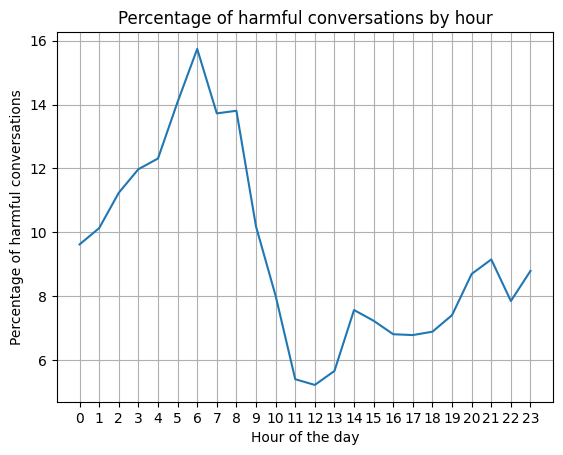

In [10]:
# Plot the percentage of harmful conversations by time of the day
harmful_df = wildchat_df.select("conversation_hash", "conversation", "openai_moderation", "turn", "offseted_timestamp")

harmful_df = harmful_df.withColumn("hour_bin", F.hour("offseted_timestamp"))

# we determine a conversation is harmful if any message in the conversation is flagged as harmful
# create a column to check if the conversation is harmful
harmful_df = harmful_df.withColumn("is_harmful", F.array_contains(F.col("openai_moderation.flagged"), True))

# Count the number of harmful conversations
num_harmful = harmful_df.filter(F.col("is_harmful")).count()
print(f"Number of harmful conversations: {num_harmful:,}")

# Count the number of harmful conversations by hour
harmful_hour_counts = harmful_df.filter(F.col("is_harmful")).groupBy("hour_bin").agg(F.count("*").alias("num_harm")).orderBy("hour_bin")

# Count the total number of conversations by hour
total_hour_counts = harmful_df.groupBy("hour_bin").agg(F.count("*").alias("total_harm")).orderBy("hour_bin")

# Calculate the percentage of harmful conversations by hour
hourly_percentage = harmful_hour_counts.join(total_hour_counts, "hour_bin")
hourly_percentage = hourly_percentage.withColumn("percentage", (F.col("num_harm") / F.col("total_harm")).cast("double") * 100)
hourly_percentage = hourly_percentage.orderBy("hour_bin")

# Plot the percentage of harmful conversations by hour
hourly_percentage_pd = hourly_percentage.toPandas()
plt.plot(hourly_percentage_pd["hour_bin"], hourly_percentage_pd["percentage"])
plt.xticks(range(0, 24))
plt.xlabel("Hour of the day")
plt.ylabel("Percentage of harmful conversations")
plt.title("Percentage of harmful conversations by hour")
plt.grid(True)
plt.show()


#### Check for specific type of harm at peak times

In [34]:
# Filter out conversations from 4 to 8 am and 20-23
# harmful_df_filtered = harmful_df.filter(F.col("is_harmful")).filter((F.col("hour_bin") >= 4) & (F.col("hour_bin") <= 8))
harmful_df_filtered = harmful_df.filter(F.col("is_harmful")).filter((F.col("hour_bin") >= 20) & (F.col("hour_bin") <= 23))

# Extract the specific harmful flags in a list from the openai_moderation column, the content of openai_moderation look like this:
# [
#     {
#         "categories": {
# 			"harassment": false,
# 			"harassment/threatening": false,
# 			"harassment_threatening": false,
# 			"hate": false,
# 			"hate/threatening": false,
# 			"hate_threatening": false,
# 			"self-harm": false,
# 			"self-harm/instructions": false,
# 			"self-harm/intent": false,
# 			"self_harm": false,
# 			"self_harm_instructions": false,
# 			"self_harm_intent": false,
# 			"sexual": false,
# 			"sexual/minors": false,
# 			"sexual_minors": false,
# 			"violence": true,
# 			"violence/graphic": false,
# 			"violence_graphic": false
# 		},
# 		"category_scores": ...
# 	},
# ...
# ]

# We have to extract harmful categories that are set to true
# Define a UDF to extract dynamically the harmful flags that are set to True
def extract_harmful_flags(categories):
	if categories:
		harmful_flags = []
		for category in categories:
			if category is not None:
				for key, value in category.asDict().items():
					if value and key not in harmful_flags:
						harmful_flags.append(key)
		return harmful_flags
	else:
		raise ValueError("Categories is empty")

# Register the UDF
extract_harmful_flags_udf = F.udf(extract_harmful_flags, ArrayType(StringType()))

# Apply the UDF to extract harmful flags dynamically
harmful_df_filtered = harmful_df_filtered.withColumn(
	"harmful_flags", 
	extract_harmful_flags_udf(F.col("openai_moderation.categories"))
)

harmful_df_filtered.select("harmful_flags").show(10, truncate=False)

+------------------------------------+
|harmful_flags                       |
+------------------------------------+
|[hate/threatening, hate_threatening]|
|[harassment]                        |
|[sexual]                            |
|[violence, sexual]                  |
|[violence]                          |
|[sexual]                            |
|[violence]                          |
|[violence]                          |
|[sexual]                            |
|[violence]                          |
+------------------------------------+
only showing top 10 rows



In [35]:
# Collect all the harmful flags and their counts
harmful_flags = harmful_df_filtered.select(F.explode("harmful_flags").alias("harmful_flag")).groupBy("harmful_flag").count().orderBy(F.desc("count"))
harmful_flags.show()


+--------------------+-----+
|        harmful_flag|count|
+--------------------+-----+
|              sexual|12789|
|            violence| 4401|
|          harassment| 3224|
|                hate|  631|
|harassment_threat...|  513|
|harassment/threat...|  513|
|    violence/graphic|  281|
|    violence_graphic|  281|
|           self_harm|  251|
|           self-harm|  251|
|    hate/threatening|  190|
|    hate_threatening|  190|
|    self-harm/intent|  164|
|    self_harm_intent|  164|
|self-harm/instruc...|   65|
|self_harm_instruc...|   65|
+--------------------+-----+



4 to 8 am:
+--------------------+-----+
|        harmful_flag|count|
+--------------------+-----+
|              sexual| 9075|
|            violence| 2875|
|          harassment| 1421|
|                hate|  262|
|harassment_threat...|  206|
|harassment/threat...|  206|
|    violence/graphic|  203|

20 to 23:
+--------------------+-----+
|        harmful_flag|count|
+--------------------+-----+
|              sexual|12789|
|            violence| 4401|
|          harassment| 3224|
|                hate|  631|
|harassment_threat...|  513|
|harassment/threat...|  513|
|    violence/graphic|  281|


#### Compare different day of weeks

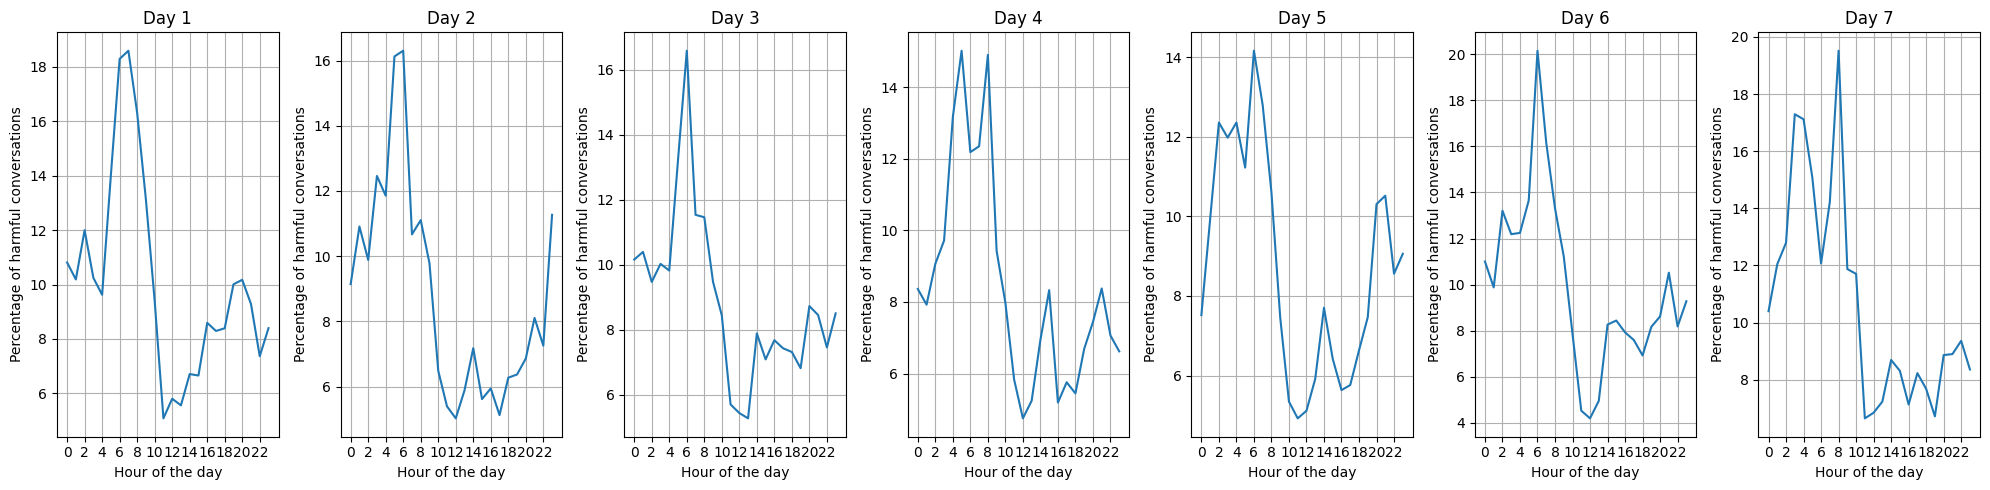

In [38]:
# Group by hour_bin, and day of the week and count the number of harmful conversations
harmful_df = harmful_df.withColumn("day_of_week", F.dayofweek("offseted_timestamp"))
harmful_flags_hourly = harmful_df.filter(F.col("is_harmful")).groupBy("day_of_week", "hour_bin").agg(F.count("*").alias("num_harm")).orderBy("day_of_week", "hour_bin")

# Count the total number of conversations by hour
total_hour_counts = harmful_df.groupBy("day_of_week", "hour_bin").agg(F.count("*").alias("total_harm")).orderBy("day_of_week", "hour_bin")

# Calculate the percentage of harmful conversations by hour
hourly_percentage = harmful_flags_hourly.join(total_hour_counts, ["day_of_week", "hour_bin"])
hourly_percentage = hourly_percentage.withColumn("percentage", (F.col("num_harm") / F.col("total_harm")).cast("double") * 100)
hourly_percentage = hourly_percentage.orderBy("day_of_week", "hour_bin")

# Plot the percentage of harmful conversations by hour, 7 figures for 7 days
hourly_percentage_pd = hourly_percentage.toPandas()

fig, axes = plt.subplots(1, 7, figsize=(20, 5))

for i in range(1, 8):
	day_data = hourly_percentage_pd[hourly_percentage_pd["day_of_week"] == i]
	axes[i-1].plot(day_data["hour_bin"], day_data["percentage"])
	axes[i-1].set_title(f"Day {i}")
	axes[i-1].set_xlabel("Hour of the day")
	axes[i-1].set_ylabel("Percentage of harmful conversations")
	axes[i-1].set_xticks(range(0, 24, 2))
	# add grid
	axes[i-1].grid()

plt.tight_layout()
plt.show()


In [ ]:
# harmful analysis